<a href="https://www.kaggle.com/code/dilekdd/telco-churn-project?scriptVersionId=201050295" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="text-align: center; font-size: 40px; font-weight: bold; color: hotpink;">
     Churn - Telecommunication
</div>


A machine learning model is expected to be developed to accurately predict which customers are at risk of leaving the company (churning).

Telco churn data includes information about an imaginary telecom company that provided home phone and Internet services to 7,043 customers in California in the third quarter. It shows which customers churned, stayed, or signed up for their service.

Data Dictionary

| **Feature**       | **Description**                                                                                       |
|-------------------|-------------------------------------------------------------------------------------------------------|
| CustomerId        | Customer's unique ID                                                                                  |
| Gender            | Gender of the customer                                                                                |
| SeniorCitizen     | Whether the customer is a senior citizen (1, 0)                                                       |
| Partner           | Whether the customer has a partner (Yes, No)                                                          |
| Dependents        | Whether the customer has dependents (Yes, No)                                                         |
| Tenure            | Number of months the customer has stayed with the company                                             |
| PhoneService      | Whether the customer has phone service (Yes, No)                                                      |
| MultipleLines     | Whether the customer has multiple lines (Yes, No, No phone service)                                   |
| InternetService   | Customer's internet service provider (DSL, Fiber optic, No)                                           |
| OnlineSecurity    | Whether the customer has online security (Yes, No, No internet service)                               |
| OnlineBackup      | Whether the customer has online backup (Yes, No, No internet service)                                 |
| DeviceProtection  | Whether the customer has device protection (Yes, No, No internet service)                             |
| TechSupport       | Whether the customer receives technical support (Yes, No, No internet service)                        |
| StreamingTV       | Whether the customer has streaming TV service (Yes, No, No internet service)                          |
| StreamingMovies   | Whether the customer has streaming movies service (Yes, No, No internet service)                      |
| Contract          | Length of the customer's contract (Month-to-month, One year, Two year)                                |
| PaperlessBilling  | Whether the customer has paperless billing (Yes, No)                                                  |
| PaymentMethod     | Customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) |
| MonthlyCharges    | The amount charged to the customer monthly                                                            |
| TotalCharges      | The total amount charged to the customer                                                              |
| Churn             | Whether the customer churned (Yes, No)                                                                

In [1]:
#importing the required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report,  RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

# import warnings
# warnings.simplefilter(action="ignore")


In [2]:
#adjusting the display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#reading the dataset
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
#function for getting a summary of the dataset
def quick_summary(dataframe, head=2):
    print("##################### HEAD #####################")
    print(dataframe .head(head))
    print("##################### TAIL #####################")
    print(dataframe.tail(head))
    print("##################### SHAPE #####################")
    print(dataframe.shape)
    print("##################### MISSING VALUES #####################")
    print(dataframe.isnull().sum())
    print("##################### QUANTILES #####################")
    print(dataframe.describe().T)
    print("##################### INFO #####################")
    print(dataframe.info())
quick_summary(df)

##################### HEAD #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling     PaymentMethod  MonthlyCharges TotalCharges Churn
0  7590-VHVEG  Female              0     Yes         No       1           No  No phone service             DSL             No          Yes               No          No          No              No  Month-to-month              Yes  Electronic check          29.850        29.85    No
1  5575-GNVDE    Male              0      No         No      34          Yes                No             DSL            Yes           No              Yes          No          No              No        One year               No      Mailed check          56.950       1889.5    No
##################### TAIL #####################
      customerID gender  SeniorCitizen Partner Dependent

In [5]:
#identifying and classifying the dataset
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Provides the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables with numeric appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                Dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Threshold value for numeric but categorical variables
        car_th: int, optinal
                Threshold for categorical but not cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                categorical but cardinal list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total variable count
        num_but_cat is included in cat_cols
        3 lists that is returned are equal to the total variable count: cat_cols + num_cols + cat_but_car = total variable count

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes in ["int", "float"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   str(dataframe[col].dtypes) in ["category", "object"]]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 2
cat_but_car: 2
num_but_cat: 1


In [6]:
#converting SeniorCitizen to object type
df["SeniorCitizen"] = df["SeniorCitizen"].astype("object")

In [7]:
#converting TotalCharges data type to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

#changing the representation of Churn variable
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == 'Yes' else 0)

In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
df["Churn"].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [11]:
df['Churn'].value_counts(normalize=True) * 100 # #imbalanced distribution

Churn
0   73.463
1   26.537
Name: proportion, dtype: float64

        gender  Ratio
gender               
Male      3555 50.476
Female    3488 49.524
##########################################


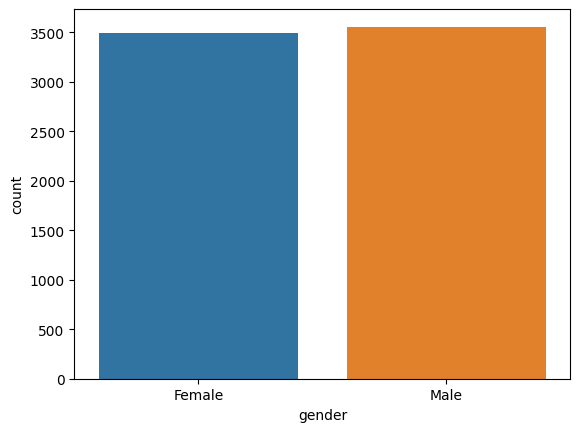

               SeniorCitizen  Ratio
SeniorCitizen                      
0                       5901 83.785
1                       1142 16.215
##########################################


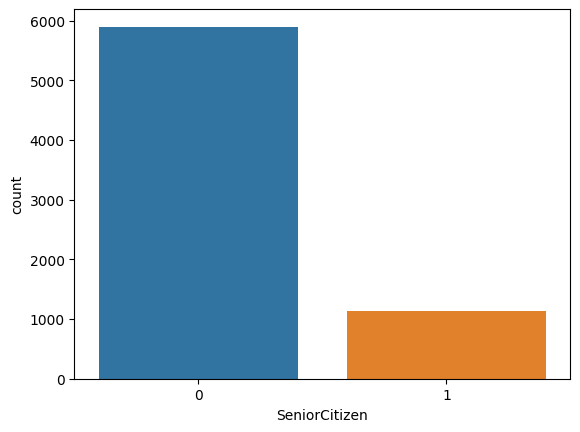

         Partner  Ratio
Partner                
No          3641 51.697
Yes         3402 48.303
##########################################


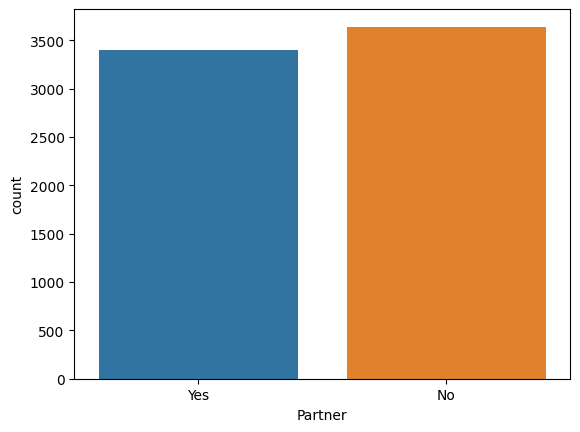

            Dependents  Ratio
Dependents                   
No                4933 70.041
Yes               2110 29.959
##########################################


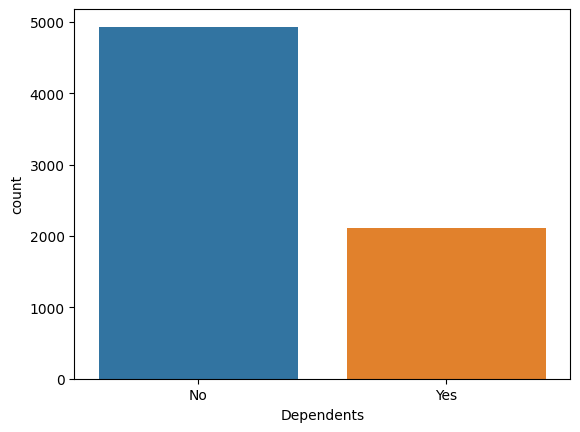

              PhoneService  Ratio
PhoneService                     
Yes                   6361 90.317
No                     682  9.683
##########################################


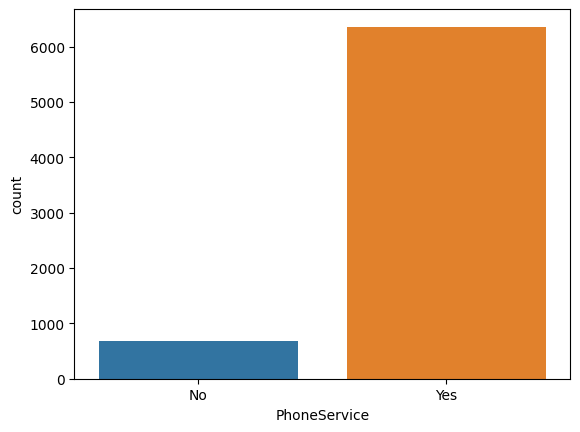

                  MultipleLines  Ratio
MultipleLines                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################


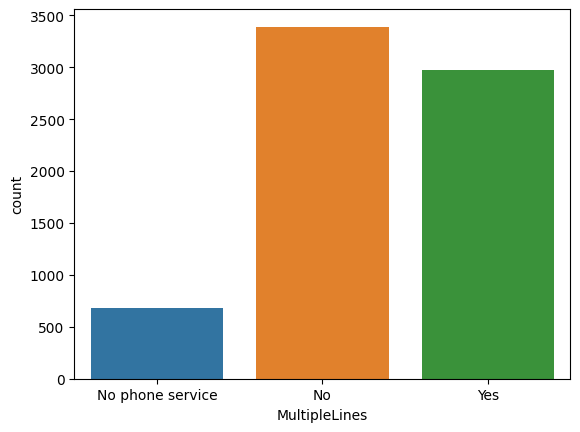

                 InternetService  Ratio
InternetService                        
Fiber optic                 3096 43.959
DSL                         2421 34.375
No                          1526 21.667
##########################################


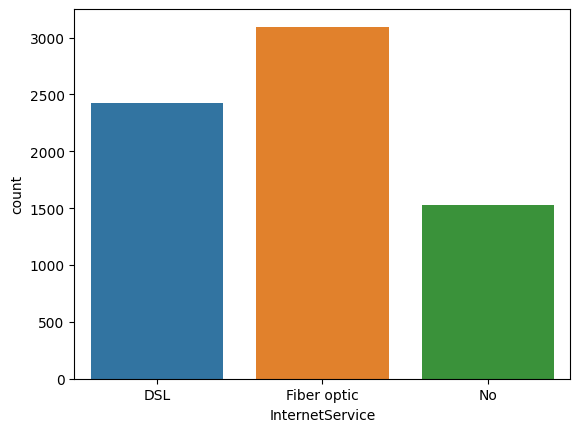

                     OnlineSecurity  Ratio
OnlineSecurity                            
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667
##########################################


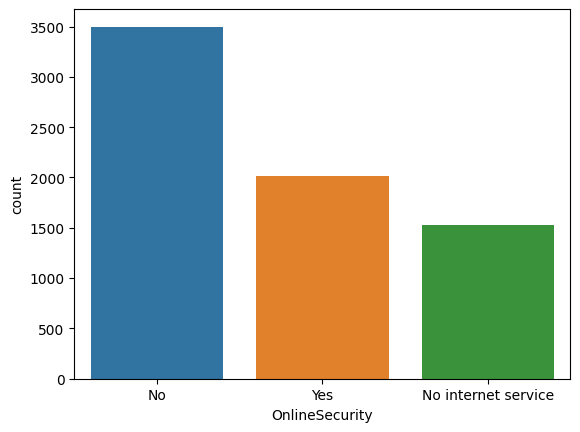

                     OnlineBackup  Ratio
OnlineBackup                            
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667
##########################################


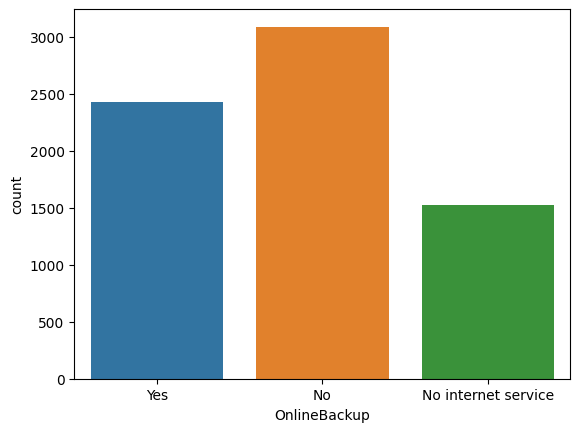

                     DeviceProtection  Ratio
DeviceProtection                            
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667
##########################################


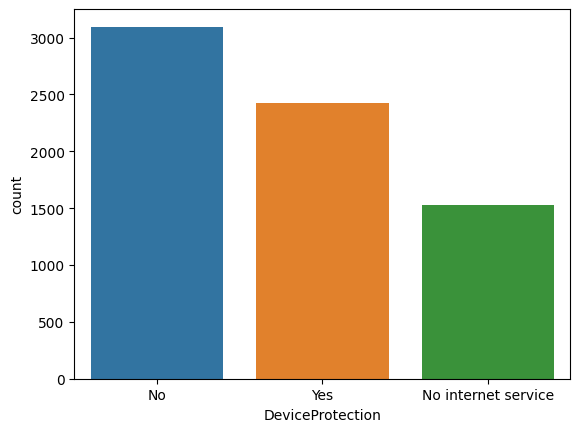

                     TechSupport  Ratio
TechSupport                            
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667
##########################################


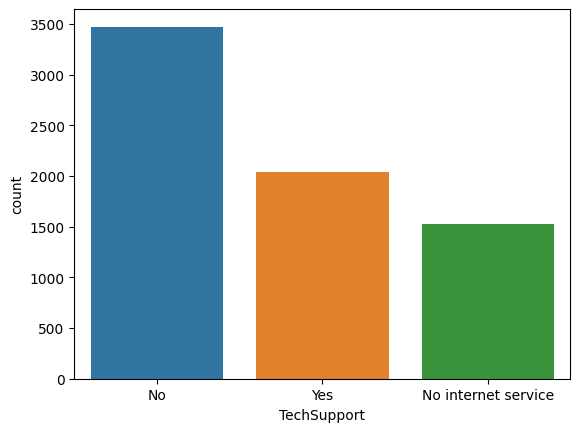

                     StreamingTV  Ratio
StreamingTV                            
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667
##########################################


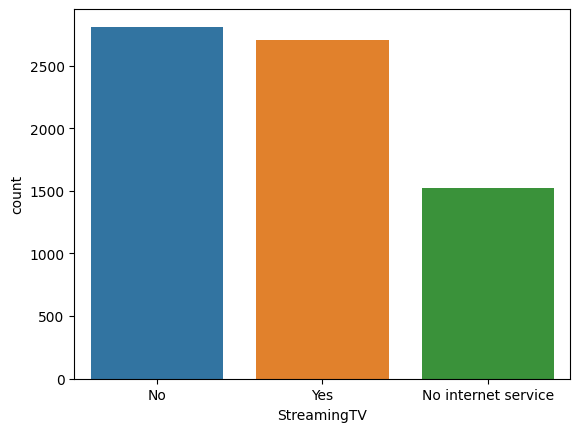

                     StreamingMovies  Ratio
StreamingMovies                            
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667
##########################################


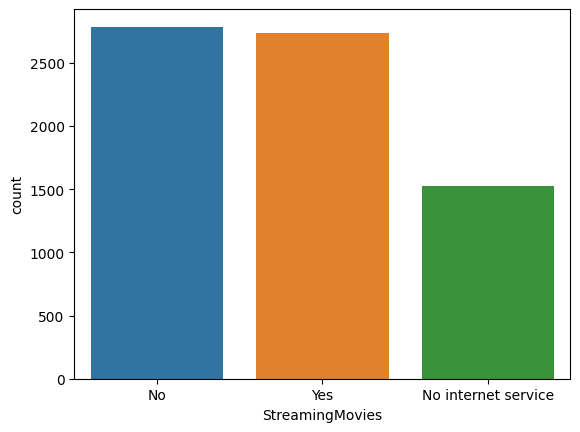

                Contract  Ratio
Contract                       
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914
##########################################


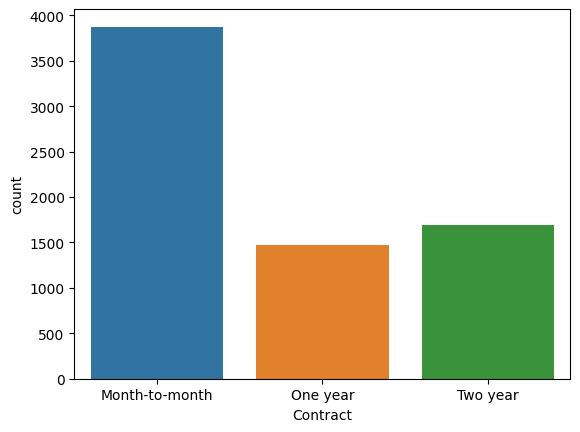

                  PaperlessBilling  Ratio
PaperlessBilling                         
Yes                           4171 59.222
No                            2872 40.778
##########################################


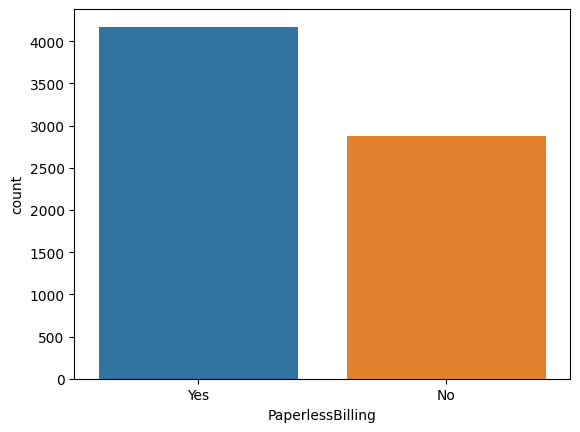

                           PaymentMethod  Ratio
PaymentMethod                                  
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610
##########################################


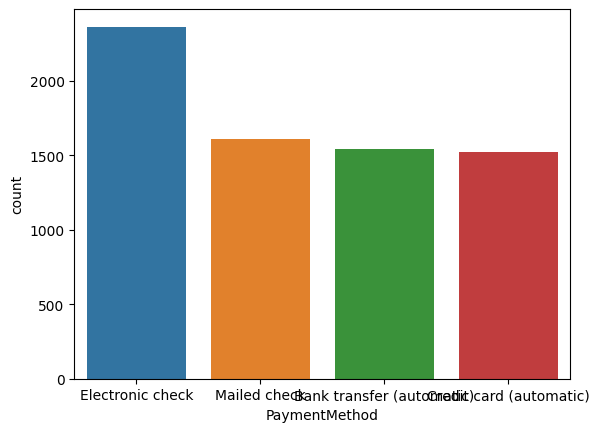

       Churn  Ratio
Churn              
0       5174 73.463
1       1869 26.537
##########################################


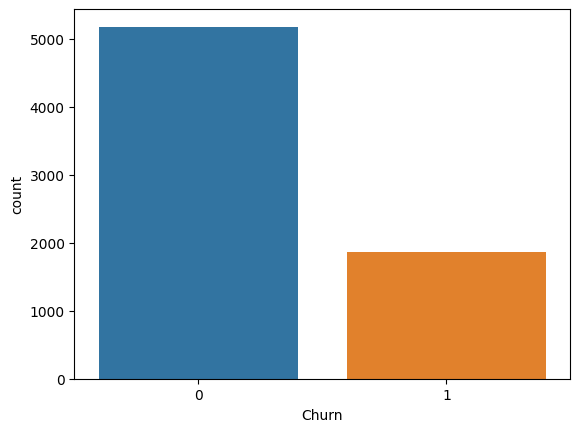

In [12]:
#summarising the categorical variables
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

# Kategorik kolonlar için fonksiyonu çalıştırma
for col in cat_cols:
    cat_summary(df, col, plot=True)

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


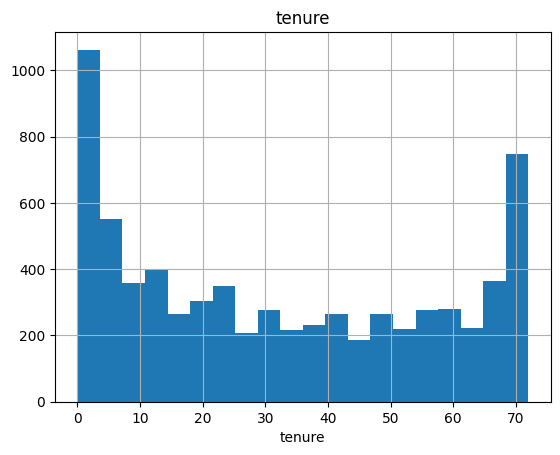

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


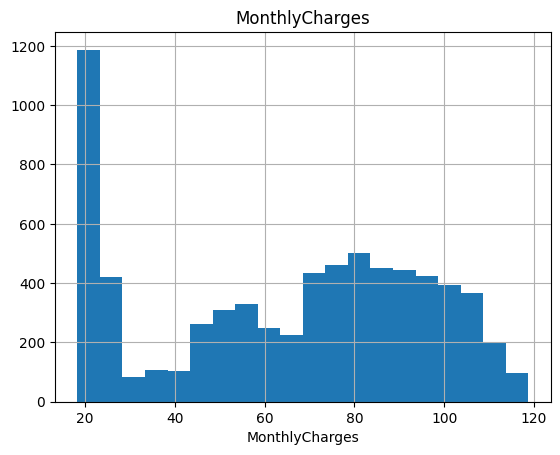

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


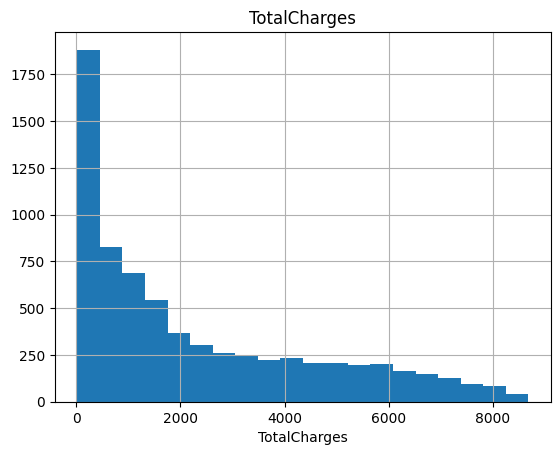

In [13]:
#summarising the numerical variables
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

In [14]:
#checking the details of target variable relations with categorical variables
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)


gender
        TARGET_MEAN  Count  Ratio
gender                           
Female        0.269   3488 49.524
Male          0.262   3555 50.476


SeniorCitizen
               TARGET_MEAN  Count  Ratio
SeniorCitizen                           
0                    0.236   5901 83.785
1                    0.417   1142 16.215


Partner
         TARGET_MEAN  Count  Ratio
Partner                           
No             0.330   3641 51.697
Yes            0.197   3402 48.303


Dependents
            TARGET_MEAN  Count  Ratio
Dependents                           
No                0.313   4933 70.041
Yes               0.155   2110 29.959


PhoneService
              TARGET_MEAN  Count  Ratio
PhoneService                           
No                  0.249    682  9.683
Yes                 0.267   6361 90.317


MultipleLines
                  TARGET_MEAN  Count  Ratio
MultipleLines                              
No                      0.250   3390 48.133
No phone service        0.249    682  9

In [15]:
#target variable with numerical variables
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Churn", col)

       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796




In [16]:
#function for defining outlier threshold
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

#replacing the outliers
# def replace_with_thresholds(dataframe, variable):
#     low_limit, up_limit = outlier_thresholds(dataframe, variable)
#     dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
#     dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


#checking to see if there is outliers 
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


# for col in num_cols:
#     replace_with_thresholds(df, col)

#applying the check_outlier function to all num_cols
for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False
TotalCharges False


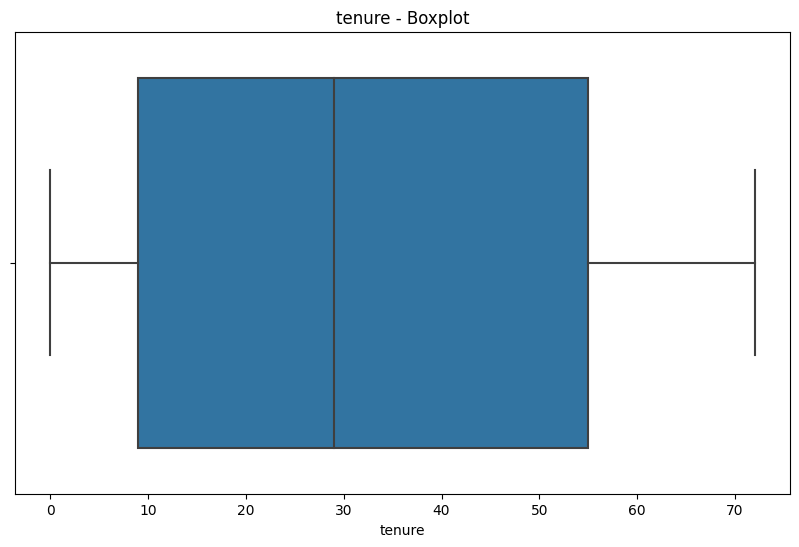

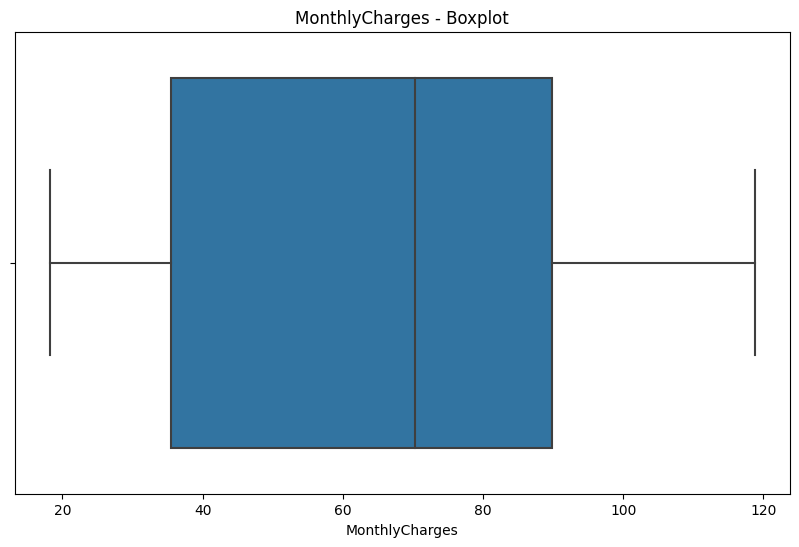

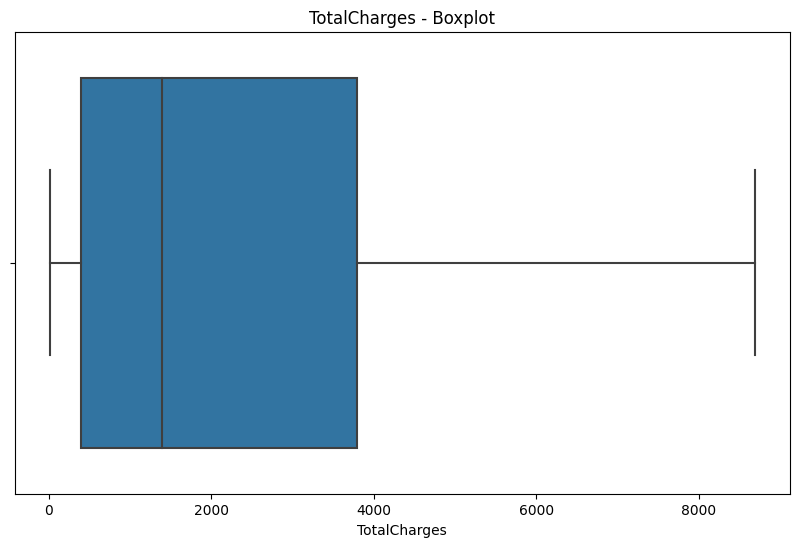

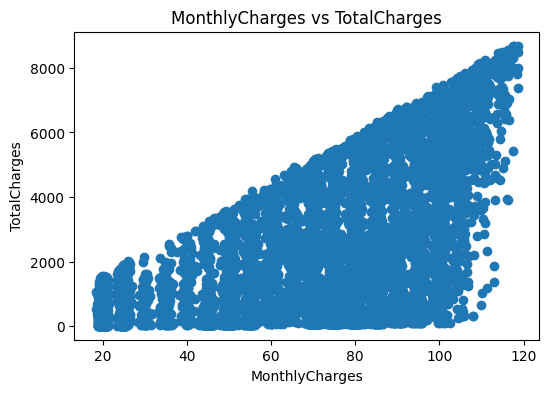

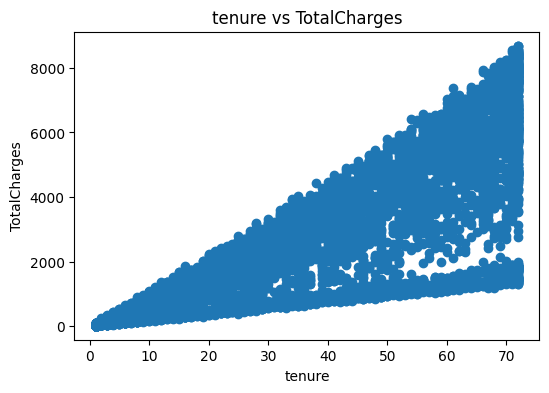

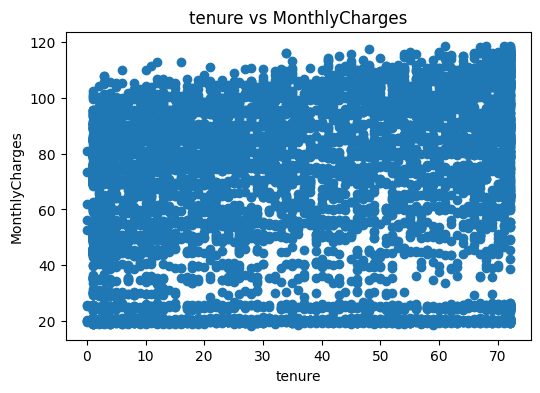

In [17]:
#plots to see the distribution of num_cols

for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.title(f"{col} - Boxplot")
    plt.show()



plt.figure(figsize=(6, 4))
plt.scatter(df['MonthlyCharges'], df['TotalCharges'])
plt.title('MonthlyCharges vs TotalCharges')
plt.xlabel('MonthlyCharges')
plt.ylabel('TotalCharges')
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(df['tenure'], df['TotalCharges'])
plt.title('tenure vs TotalCharges')
plt.xlabel('tenure')
plt.ylabel('TotalCharges')
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(df['tenure'], df['MonthlyCharges'])
plt.title('tenure vs MonthlyCharges')
plt.xlabel('tenure')
plt.ylabel('MonthlyCharges')
plt.show()

In [18]:
#checking the missing values
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [19]:
#11 missing TotalCharges observations with all the information
df[df["TotalCharges"].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.550,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.850,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.050,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350,NaN,0


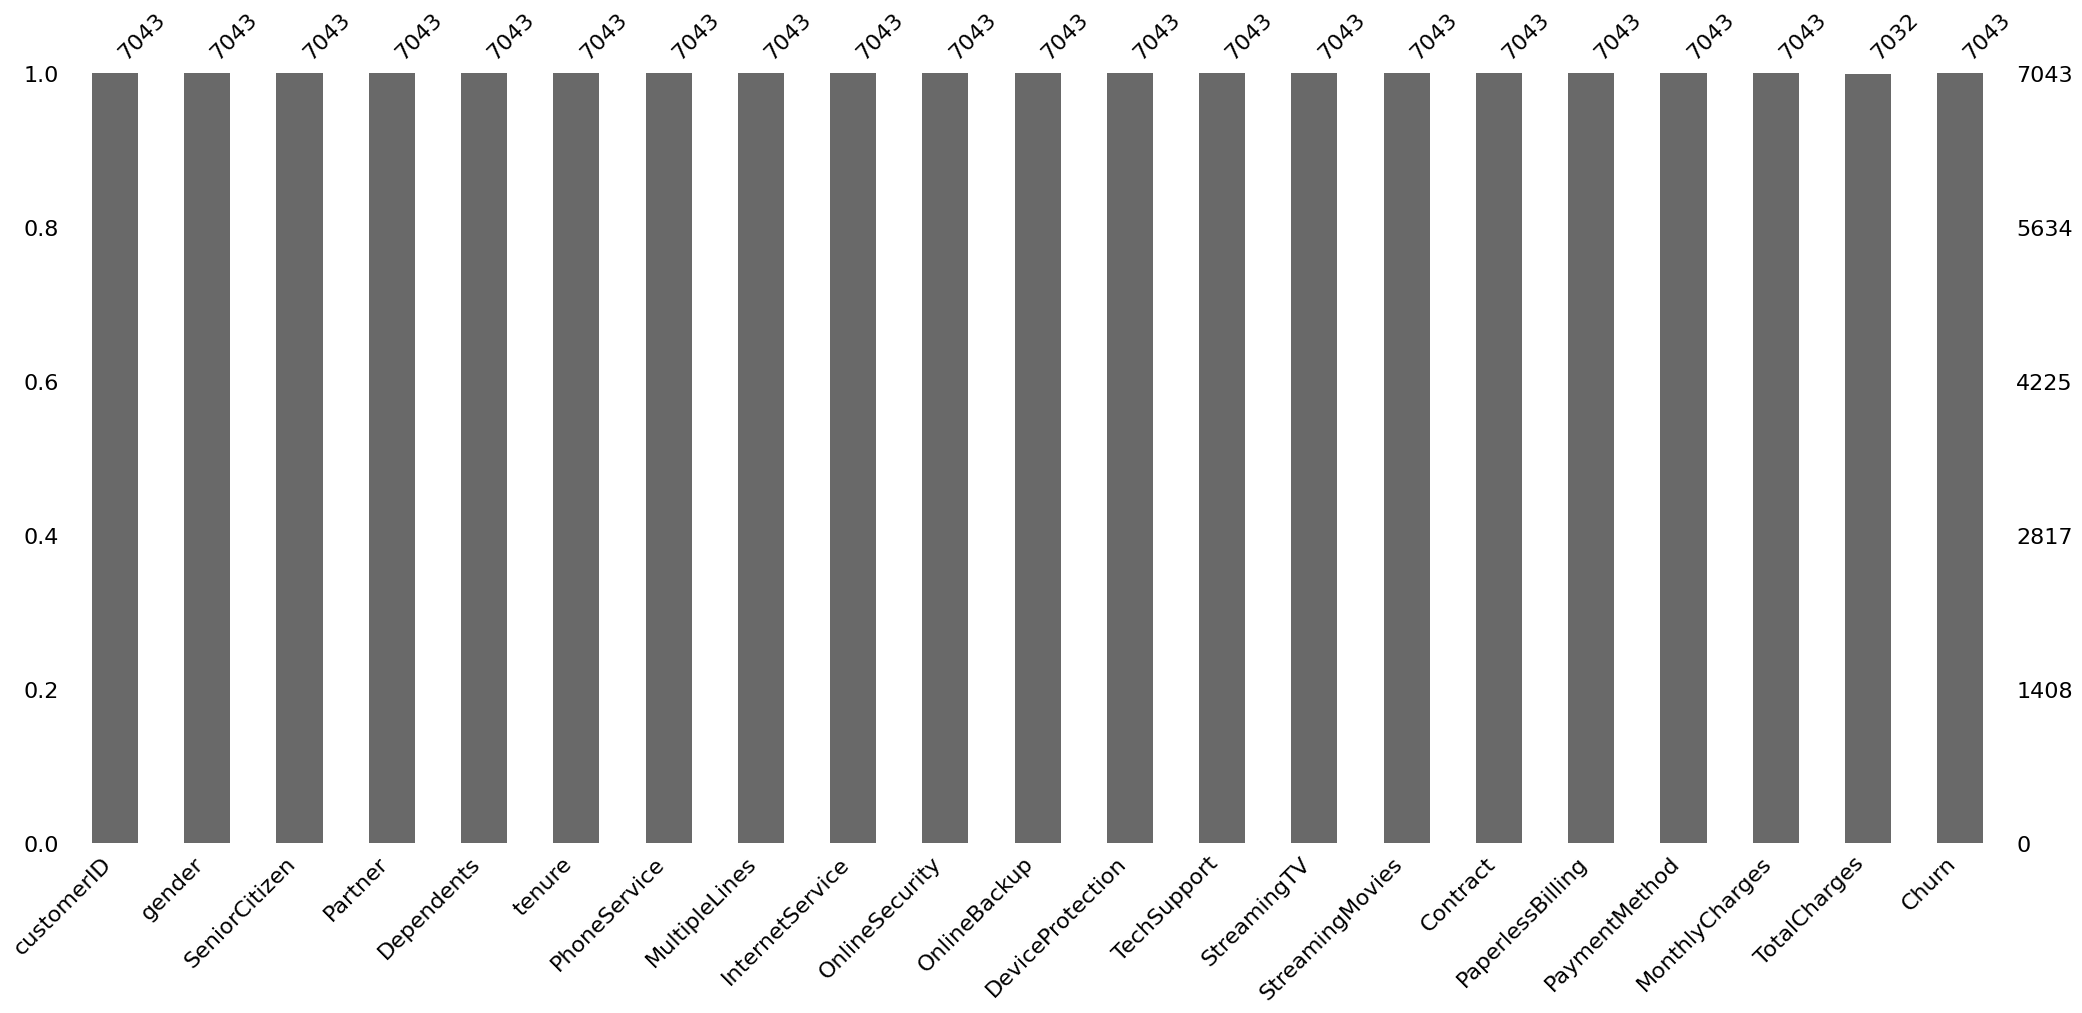

In [20]:
#displaying observations of all variables
msno.bar(df)
plt.show()

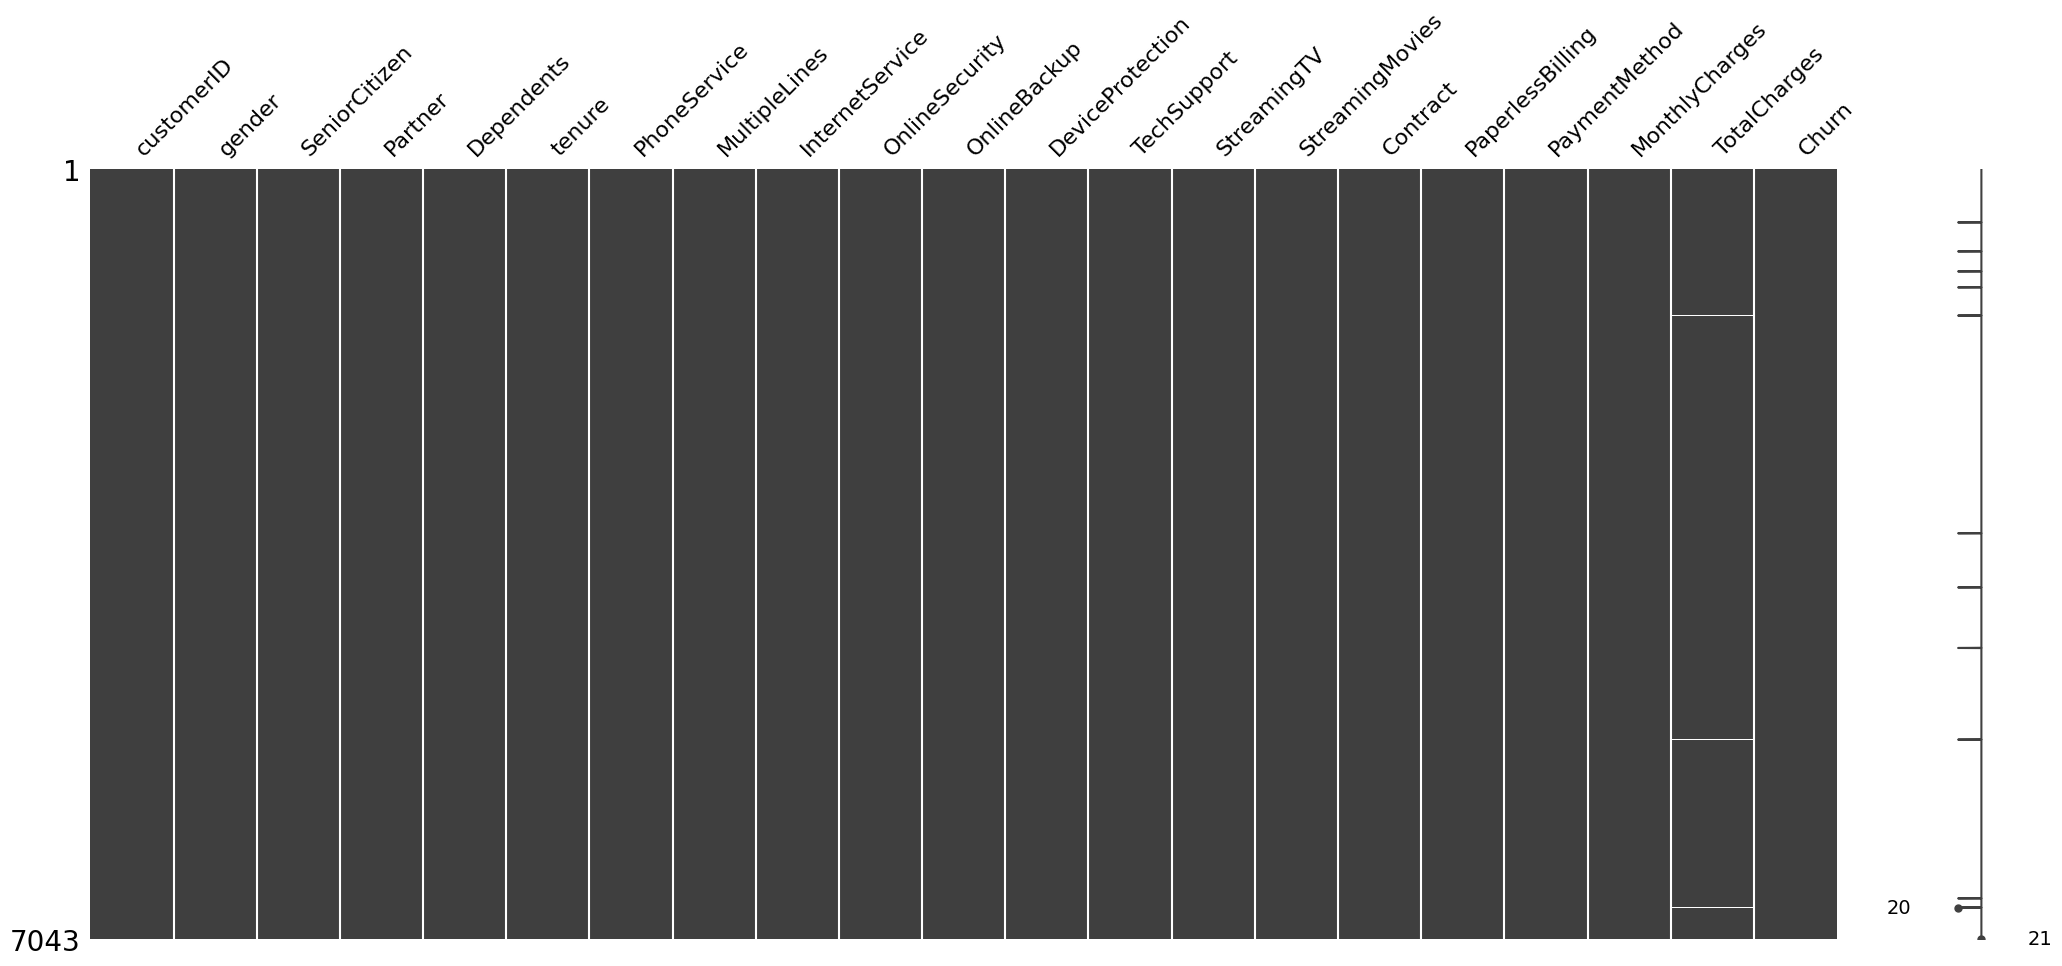

In [21]:
#displaying the missing values
msno.matrix(df)
plt.show()

In [22]:
#showing the number and percentage of missing values in each of the columns that has missing values
#returns missing values' column names
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

na_cols = missing_values_table(df, True)

              n_miss  ratio
TotalCharges      11  0.160


In [23]:
#displaying the correlation between the missing variables and target
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Churn", na_cols)

                      TARGET_MEAN  Count
TotalCharges_NA_FLAG                    
0                           0.266   7032
1                           0.000     11




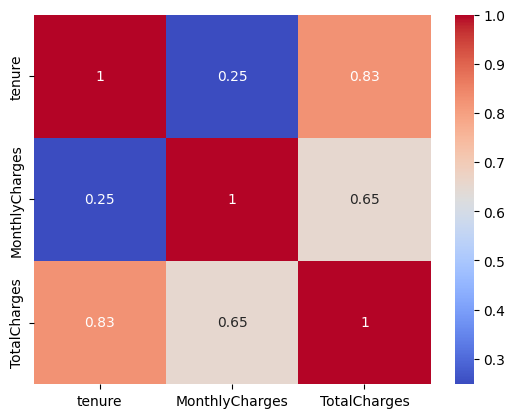

In [24]:
#correlation matrix of the numerical columns
df_corr = df[num_cols].corr()
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.show()

In [25]:
#calling the grab_col_names function
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


In [26]:
#using get_dummmies method before imputing the missing values
dff = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)

dff.head()

,Churn,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.850,29.850,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
1,0,34,56.950,1889.500,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
2,1,2,53.850,108.150,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,0,45,42.300,1840.750,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False
4,1,2,70.700,151.650,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False


In [27]:
#scaling the dataframe
scaler = MinMaxScaler()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
dff.head()

,Churn,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.000,0.014,0.115,0.001,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000
1,0.000,0.472,0.385,0.216,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000
2,1.000,0.028,0.354,0.010,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000
3,0.000,0.625,0.239,0.210,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
4,1.000,0.028,0.522,0.015,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000


In [28]:
#imputing the missing values by using KNNImputer (meadian value of the 5 neighbours)
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
dff.head()

,Churn,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.000,0.014,0.115,0.001,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000
1,0.000,0.472,0.385,0.216,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000
2,1.000,0.028,0.354,0.010,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000
3,0.000,0.625,0.239,0.210,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
4,1.000,0.028,0.522,0.015,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000


In [29]:
#inversing the dataframe dff
dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)

In [30]:
dff.head()

,Churn,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.000,1.000,29.850,29.850,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000
1,0.000,34.000,56.950,1889.500,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000
2,1.000,2.000,53.850,108.150,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000
3,0.000,45.000,42.300,1840.750,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
4,1.000,2.000,70.700,151.650,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000


In [31]:
#assigning TotalCharges from dff dataframe to the original dataframe's TotalCharges
df["TotalCharges"] = dff["TotalCharges"]
df["TotalCharges"].isnull().sum()

0

In [32]:
#checking the outliers again
for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False
TotalCharges False


<div style="text-align: center; font-size: 18px; font-weight: bold; color: purple;">
     Creating a model without applying feature engineering
</div>

In [33]:
#copying the dataset and creating a new one
df_base = df.copy()

In [34]:
#calling out the grab_col_names with df_base dataframe 
cat_cols, num_cols, cat_but_car = grab_col_names(df_base)
cat_cols = [col for col in cat_cols if col not in ["Churn"]]


Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


In [35]:
#applying One Hot Encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df_base = one_hot_encoder(df_base, cat_cols)

In [36]:
df_base.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,29.850,29.850,0,True,False,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
1,5575-GNVDE,34,56.950,1889.500,0,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2,3668-QPYBK,2,53.850,108.150,1,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
3,7795-CFOCW,45,42.300,1840.750,0,False,True,True,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False
4,9237-HQITU,2,70.700,151.650,1,True,False,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False


In [37]:
#scaling the num_cols
rs = RobustScaler()
df_base[num_cols] = rs.fit_transform(df_base[num_cols])
df_base.describe().T
df_base.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,-0.609,-0.745,-0.403,0,True,False,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
1,5575-GNVDE,0.109,-0.247,0.145,0,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2,3668-QPYBK,-0.587,-0.304,-0.380,1,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
3,7795-CFOCW,0.348,-0.516,0.131,0,False,True,True,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False
4,9237-HQITU,-0.587,0.006,-0.368,1,True,False,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False


In [38]:
#converting bool columns to int
bool_cols = df_base.select_dtypes(include='bool').columns
df_base[bool_cols] = df_base[bool_cols].astype('int')
df_base.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,-0.609,-0.745,-0.403,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,5575-GNVDE,0.109,-0.247,0.145,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,3668-QPYBK,-0.587,-0.304,-0.380,1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,7795-CFOCW,0.348,-0.516,0.131,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,9237-HQITU,-0.587,0.006,-0.368,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [39]:
#establishing the model
y = df_base["Churn"]
X = df_base.drop(["Churn", "customerID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=24689)

X_train.shape
X_test.shape

models = [('LR', LogisticRegression(random_state=24689, max_iter=1500)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=24689)),
          ('RF', RandomForestClassifier(random_state=24689)),
          ('XGB', XGBClassifier(random_state=24689)),
          ("LightGBM", LGBMClassifier(random_state=24689, force_col_wise=True)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=24689))]

# a list that we can store the performance results of the model
results = []

# creating a for loop on models
for model_name, model in models:
    # training the model 
    model.fit(X_train, y_train)

    # prediction on Test dataset 
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # AUC için pozitif sınıfın olasılığı

    # calculating the metrics 
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # stroring the results 
    results.append({
        'Model':  model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    })

# converting the results' list to a dataframe 
import pandas as pd

result_df = pd.DataFrame(results)
result_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1482, number of negative: 4152
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263046 -> initscore=-1.030198
[LightGBM] [Info] Start training from score -1.030198


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,LR,0.806,0.690,0.535,0.603,0.854
1,KNN,0.750,0.549,0.506,0.527,0.781
2,CART,0.747,0.537,0.558,0.548,0.690
3,RF,0.787,0.645,0.499,0.563,0.832
4,XGB,0.794,0.659,0.519,0.581,0.841
5,LightGBM,0.799,0.671,0.527,0.590,0.850
6,CatBoost,0.811,0.715,0.519,0.602,0.857


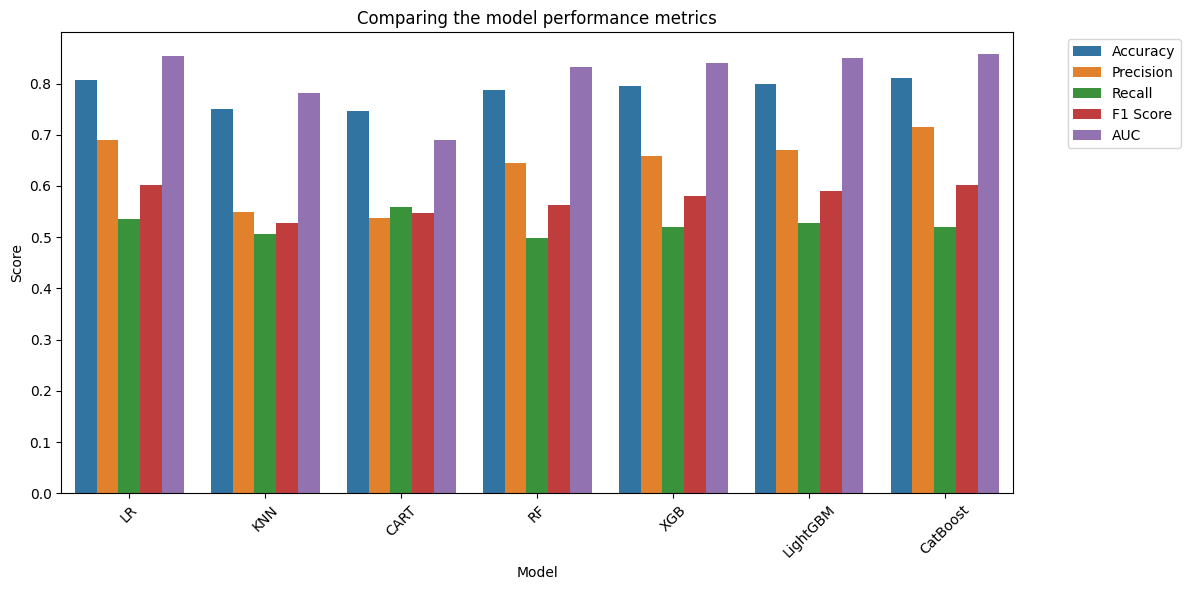

In [40]:
#plotting the performance metrics
import matplotlib.pyplot as plt
import seaborn as sns

# transforming the results_df by using 'Model' column
result_melt = result_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

# adjusting the graph size 
plt.figure(figsize=(12, 6))

# Visualizing performance metrics with Seaborn barplot
sns.barplot(x="Model", y="Value", hue="Metric", data=result_melt)

# Header and the labels 
plt.title("Comparing the model performance metrics")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)  # Legend (açıklama) konumunu ayarlama
plt.tight_layout()

# plotting
plt.show()

Feature Importance for LR:
LogisticRegression does not have feature_importances_ attribute
Feature Importance for KNN:
KNeighborsClassifier does not have feature_importances_ attribute
Feature Importance for CART:


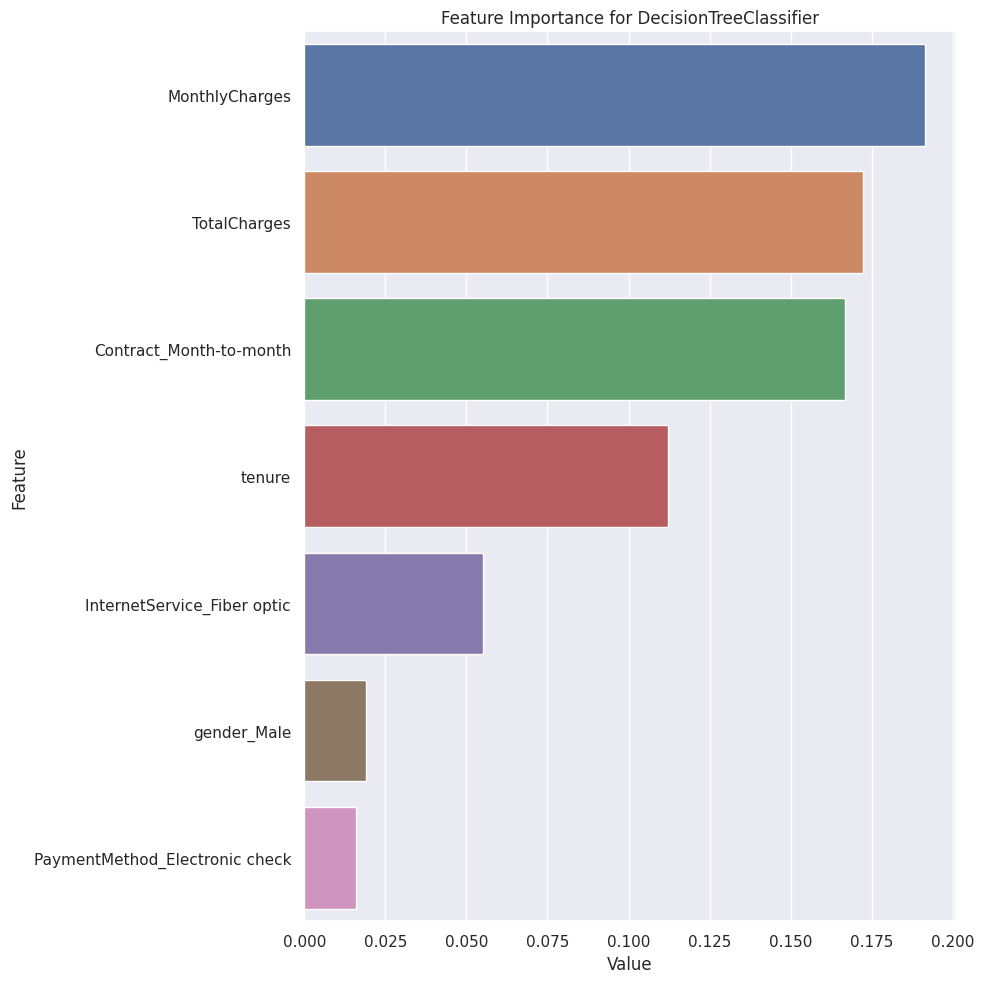

Feature Importance for RF:


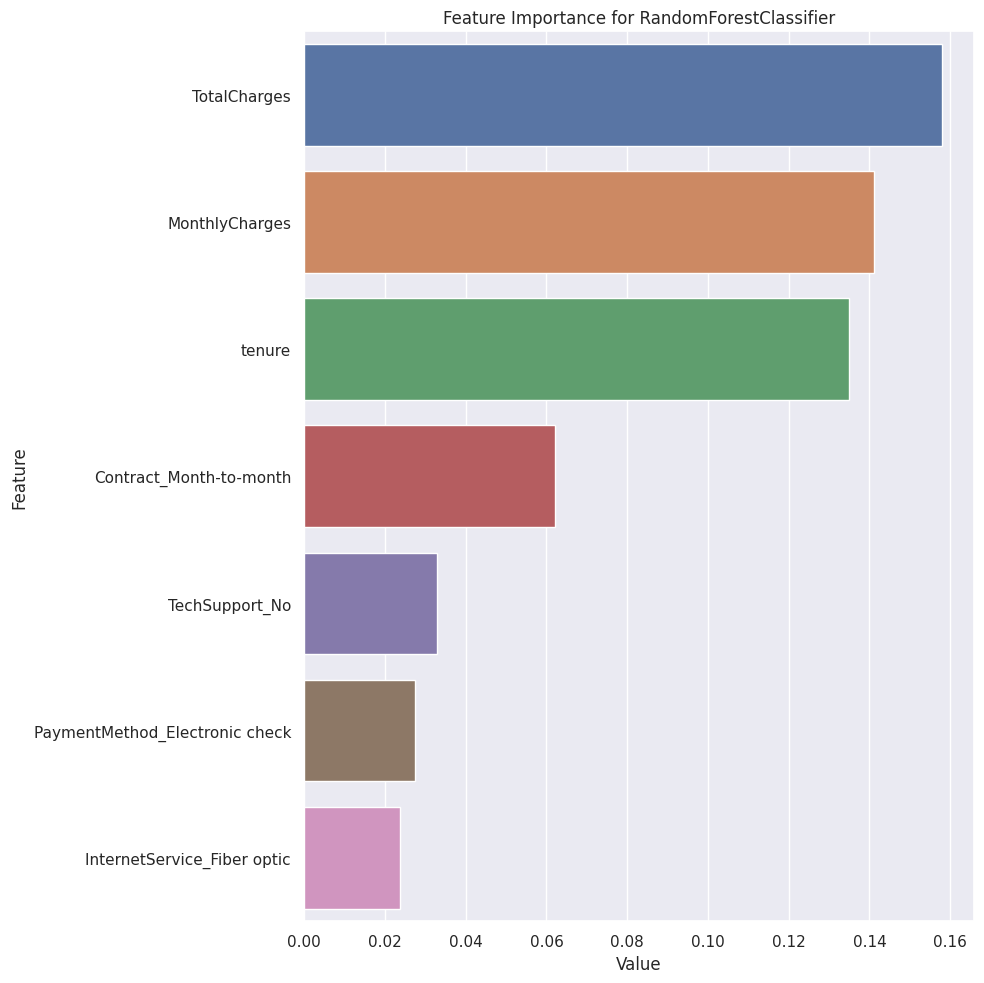

Feature Importance for XGB:


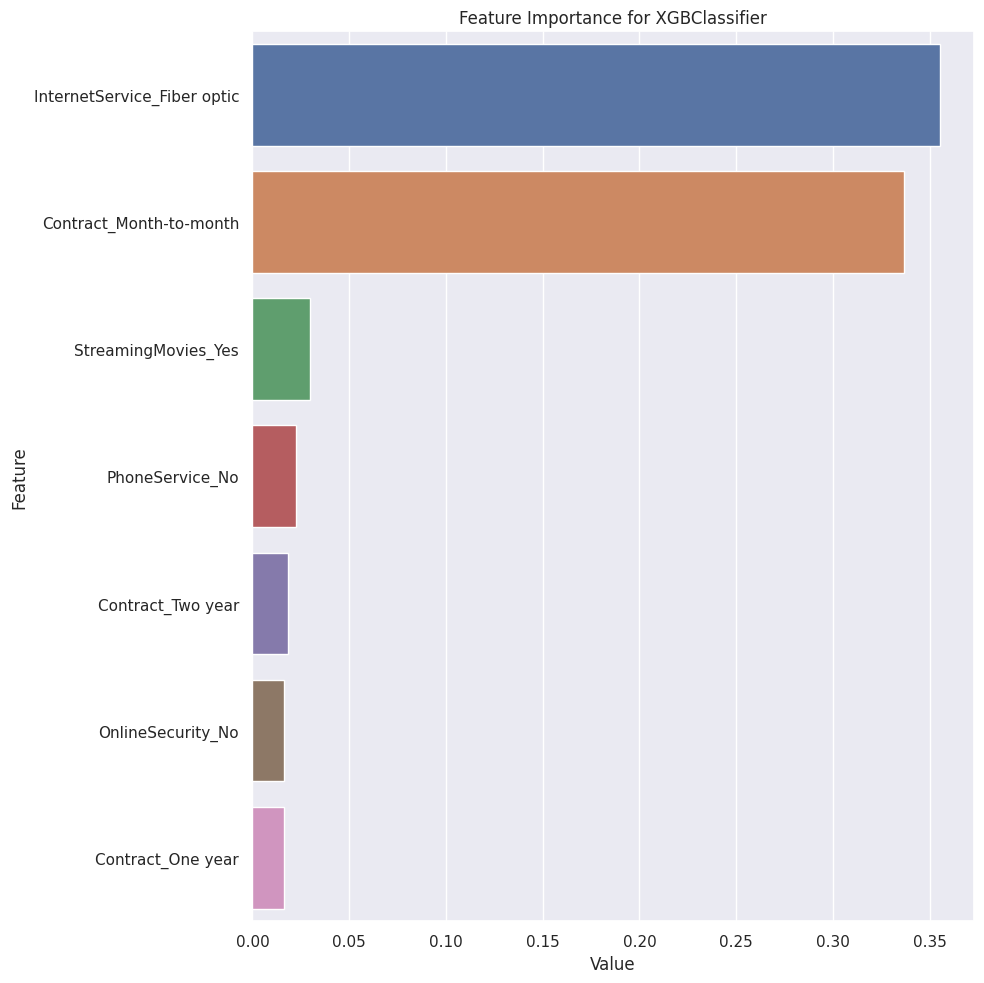

Feature Importance for LightGBM:


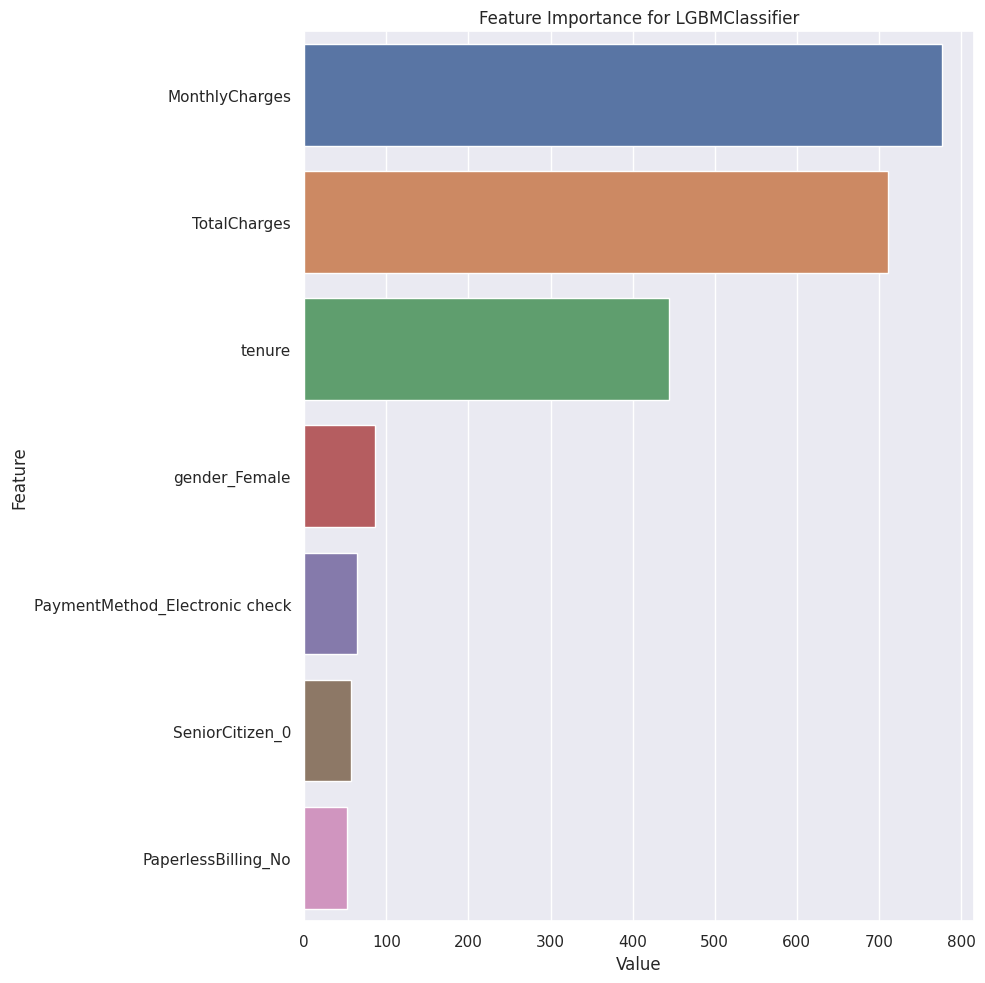

Feature Importance for CatBoost:


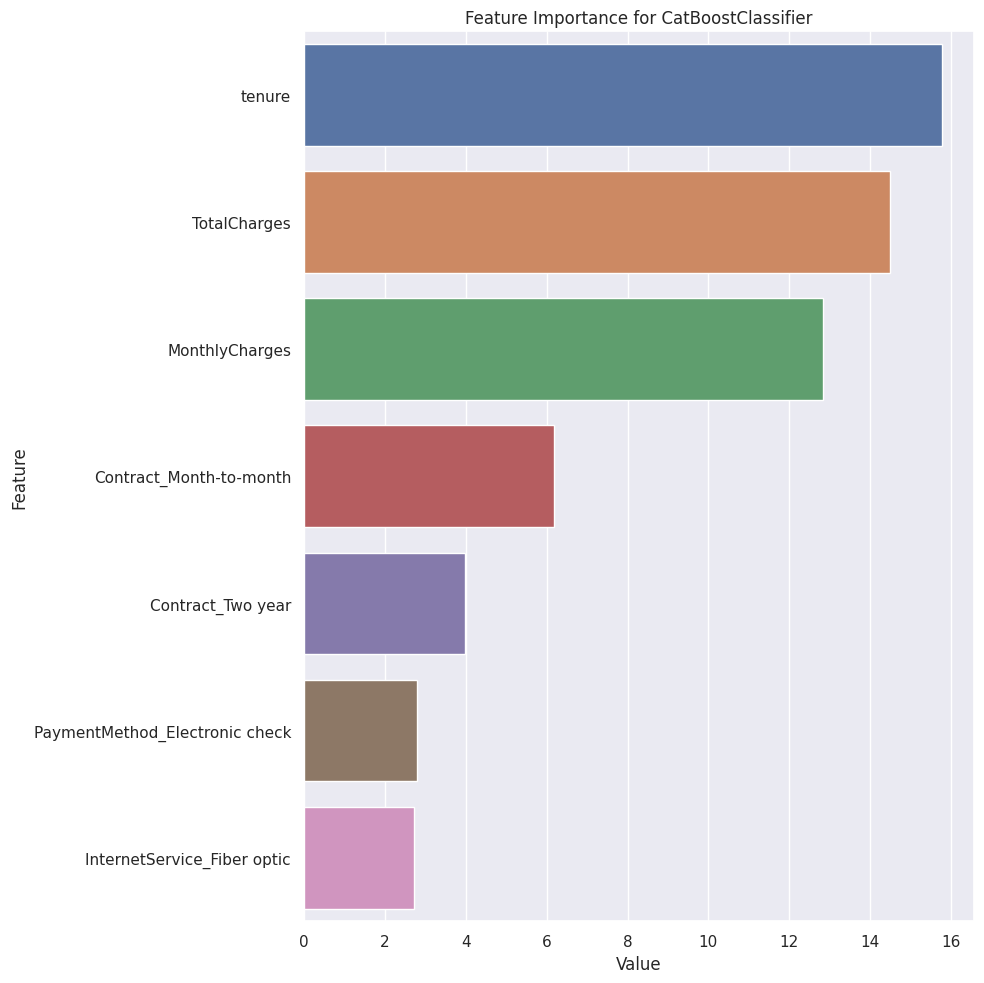

In [41]:
# function for plotting the feature importance graphs 
def plot_importance(model, features, num=len(X_train.columns), save=False):
    if hasattr(model, 'feature_importances_'):  # checking to see if the model has a feature impportance feature
        feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
        plt.title(f'Feature Importance for {type(model).__name__}')
        plt.tight_layout()
        plt.show()
        if save:
            plt.savefig(f'{type(model).__name__}_importances.png')
    else:
        print(f"{type(model).__name__} does not have feature_importances_ attribute")

# creating a loop over models 
for model_name, model in models:
    # plotting only for the models that support feature_importance feature 
    print(f"Feature Importance for {model_name}:")
    plot_importance(model, X_train, num=7)

<div style="text-align: center; font-size: 18px; font-weight: bold; color: purple;">
    Feature Engineering
</div>

In [42]:
#checking the max vale of tenure variable
df["tenure"].max()

72

In [43]:
#converting tenure variable to a categorical variable
df['New_tenure_year'] = pd.cut(df['tenure'],
                               bins=[0, 12, 24, 36, 48, 60, 72],
                               labels=['0-1 Year', '1-2 Year', '2-3 Year', '3-4 Year', '4-5 Year', '5-6 Year'],
                               right=True)

In [44]:
#checking the value_counts of the variable Contract
df["Contract"].value_counts()

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [45]:
#assigning 1 to the observations that have a contract and 0 those who have no contract
#assigning it to "New_Contract" variable
df["New_Contract"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

In [46]:
#identifying if the customer used any of OnlineBackup, DeviceProtection, TechSupport
df["New_No_Support"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

In [47]:
#calculating the total services of the customers
df['New_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                               'OnlineBackup', 'DeviceProtection', 'TechSupport',
                               'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

In [48]:
#creating New_Youth_Monthly variable to see correlation between young and those have no contract
df["New_Youth_Monthly"] = df.apply(lambda x: 1 if (x["New_Contract"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

In [49]:
df["Stability_Indicator"] = df.apply(lambda x: 1 if (x["MultipleLines"] == "No phone service") or
                                                   (x["InternetService"] == "No") else 0, axis=1)

In [50]:
#checking the values of PaymentMethod
df["PaymentMethod"].value_counts()

PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

In [51]:
#creating a new variable to identify the customers who are on auto payment
df["New_AutoPay"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

In [52]:
#deriving cltv value
df["New_value"] = df["MonthlyCharges"] * df["tenure"]

In [53]:
#new interaction to see tenure/new_contract ratio
df["New_Tenure_Contract_Ratio"] = df["tenure"] / df["New_Contract"].replace({0: 1}) 

In [54]:
#deriving the new customers who they might be potentially at high risk of churn
df["New_Charges_Ratio"] = df["MonthlyCharges"] / (df["TotalCharges"] + 1)  # Adding 1 to avoid division by zero

In [55]:
#creating new interactions
df["New_Average_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

df["Senior_Price_Sensitivity"] = df["SeniorCitizen"] * df["MonthlyCharges"]

df["Young_Price_Sensitivity"] = df["New_Youth_Monthly"] * df["MonthlyCharges"]

df["Tenure_Monthly_Interaction"] = df["tenure"] * df["MonthlyCharges"]

df["Contract_Service_Interaction"] = df["New_Contract"] * df["New_TotalServices"]


In [56]:
df["New_MonthlyCharges_Binned"] = pd.qcut(df["MonthlyCharges"], q=4, labels=["Low", "Medium", "High", "Very High"])

In [57]:

# New Average Order Value: TotalCharges per tenure
df["New_Average_Order_Value"] = df["TotalCharges"] / (df["tenure"] + 1)  # Handle tenure = 0

# New Purchase Frequency: Tenure divided by contract length
df["New_Purchase_Frequency"] = df["tenure"] / (df["New_Contract"] + 1)  # Assuming 'New_Contract' is a valid proxy

# Customer Value: Combination of Average Order Value and Purchase Frequency
df["New_Customer_Value"] = df["New_Average_Order_Value"] * df["New_Purchase_Frequency"]

# Calculate the total number of customers
total_customers = df.shape[0]

# Calculate the number of customers who churned
churned_customers = df[df["Churn"] == 1].shape[0]

# Calculate Churn Rate
churn_rate = churned_customers / total_customers

# Calculate Repeat Rate (1 - Churn Rate)
repeat_rate = 1 - churn_rate

df["New_Profit_Margin"] = df["TotalCharges"] * 0.10

df["New_CLTV_"] = (df["New_Customer_Value"] / churn_rate) * df["New_Profit_Margin"]

In [58]:
#re-calling grab_col_names function and excluding the target variable from cat_cols
cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols = [col for col in cat_cols if col not in ["Churn"]]

Observations: 7043
Variables: 42
cat_cols: 26
num_cols: 14
cat_but_car: 2
num_but_cat: 8


In [59]:
#creating label encoder function
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

binary_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling']

In [60]:
#applying the function for binary_cols
for col in binary_cols:
    df = label_encoder(df, col)

In [61]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,New_tenure_year,New_Contract,New_No_Support,New_TotalServices,New_Youth_Monthly,Stability_Indicator,New_AutoPay,New_value,New_Tenure_Contract_Ratio,New_Charges_Ratio,New_Average_Charges,Senior_Price_Sensitivity,Young_Price_Sensitivity,Tenure_Monthly_Interaction,Contract_Service_Interaction,New_MonthlyCharges_Binned,New_Average_Order_Value,New_Purchase_Frequency,New_Customer_Value,New_Profit_Margin,New_CLTV_
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,1,0,29.850,1.000,0.968,14.925,0.000,29.850,29.850,0,Low,14.925,1.000,14.925,2.985,167.883
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.950,1889.500,0,2-3 Year,1,1,3,0,0,0,1936.300,34.000,0.030,53.986,0.000,0.000,1936.300,3,Medium,53.986,17.000,917.757,188.950,653466.091
2,3668-QPYBK,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.850,108.150,1,0-1 Year,0,1,3,1,0,0,107.700,2.000,0.493,36.050,0.000,53.850,107.700,0,Medium,36.050,2.000,72.100,10.815,2938.395
3,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,3,0,1,1,1903.500,45.000,0.023,40.016,0.000,0.000,1903.500,3,Medium,40.016,22.500,900.367,184.075,624543.499
4,9237-HQITU,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,141.400,2.000,0.463,50.550,0.000,70.700,141.400,0,High,50.550,2.000,101.100,15.165,5777.527


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   customerID                    7043 non-null   object  
 1   gender                        7043 non-null   int64   
 2   SeniorCitizen                 7043 non-null   int64   
 3   Partner                       7043 non-null   int64   
 4   Dependents                    7043 non-null   int64   
 5   tenure                        7043 non-null   int64   
 6   PhoneService                  7043 non-null   int64   
 7   MultipleLines                 7043 non-null   object  
 8   InternetService               7043 non-null   object  
 9   OnlineSecurity                7043 non-null   object  
 10  OnlineBackup                  7043 non-null   object  
 11  DeviceProtection              7043 non-null   object  
 12  TechSupport                   7043 non-null   ob

In [63]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

#excluding target "Churn", and "New_TotalServices" variables from cat_cols
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "New_TotalServices"]]

Observations: 7043
Variables: 42
cat_cols: 26
num_cols: 14
cat_but_car: 2
num_but_cat: 14


In [64]:
#applying One Hot Encoder
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols)

In [65]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,New_TotalServices,New_value,New_Tenure_Contract_Ratio,New_Charges_Ratio,New_Average_Charges,Senior_Price_Sensitivity,Young_Price_Sensitivity,Tenure_Monthly_Interaction,New_Average_Order_Value,New_Purchase_Frequency,New_Customer_Value,New_Profit_Margin,New_CLTV_,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,New_tenure_year_0-1 Year,New_tenure_year_1-2 Year,New_tenure_year_2-3 Year,New_tenure_year_3-4 Year,New_tenure_year_4-5 Year,New_tenure_year_5-6 Year,New_MonthlyCharges_Binned_Low,New_MonthlyCharges_Binned_Medium,New_MonthlyCharges_Binned_High,New_MonthlyCharges_Binned_Very High,New_Contract_0,New_Contract_1,New_No_Support_0,New_No_Support_1,New_Youth_Monthly_0,New_Youth_Monthly_1,Stability_Indicator_0,Stability_Indicator_1,New_AutoPay_0,New_AutoPay_1,Contract_Service_Interaction_0,Contract_Service_Interaction_1,Contract_Service_Interaction_2,Contract_Service_Interaction_3,Contract_Service_Interaction_4,Contract_Service_Interaction_5,Contract_Service_Interaction_6,Contract_Service_Interaction_7
0,7590-VHVEG,0,0,1,0,1,0,1,29.850,29.850,0,1,29.850,1.000,0.968,14.925,0.000,29.850,29.850,14.925,1.000,14.925,2.985,167.883,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False,True,False,True,False,True,True,False,True,False,False,False,False,False,False,False
1,5575-GNVDE,1,0,0,0,34,1,0,56.950,1889.500,0,3,1936.300,34.000,0.030,53.986,0.000,0.000,1936.300,53.986,17.000,917.757,188.950,653466.091,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,True,True,False,True,False,True,False,False,False,False,True,False,False,False,False
2,3668-QPYBK,1,0,0,0,2,1,1,53.850,108.150,1,3,107.700,2.000,0.493,36.050,0.000,53.850,107.700,36.050,2.000,72.100,10.815,2938.395,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,True,False,True,False,True,False,False,False,False,False,False,False
3,7795-CFOCW,1,0,0,0,45,0,0,42.300,1840.750,0,3,1903.500,45.000,0.023,40.016,0.000,0.000,1903.500,40.016,22.500,900.367,184.075,624543.499,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,True,False,False,True,False,True,False,False,False,True,False,False,False,False
4,9237-HQITU,0,0,0,0,2,1,1,70.700,151.650,1,1,141.400,2.000,0.463,50.550,0.000,70.700,141.400,50.550,2.000,101.100,15.165,5777.527,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,Fals

In [66]:
#converting bool type variables to integer
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype('int')

In [67]:
#running the function grab_col_names
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 83
cat_cols: 67
num_cols: 14
cat_but_car: 2
num_but_cat: 67


In [68]:
#scaling the num_cols
rs = RobustScaler()
df[num_cols] = rs.fit_transform(df[num_cols])

In [69]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,New_TotalServices,New_value,New_Tenure_Contract_Ratio,New_Charges_Ratio,New_Average_Charges,Senior_Price_Sensitivity,Young_Price_Sensitivity,Tenure_Monthly_Interaction,New_Average_Order_Value,New_Purchase_Frequency,New_Customer_Value,New_Profit_Margin,New_CLTV_,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,New_tenure_year_0-1 Year,New_tenure_year_1-2 Year,New_tenure_year_2-3 Year,New_tenure_year_3-4 Year,New_tenure_year_4-5 Year,New_tenure_year_5-6 Year,New_MonthlyCharges_Binned_Low,New_MonthlyCharges_Binned_Medium,New_MonthlyCharges_Binned_High,New_MonthlyCharges_Binned_Very High,New_Contract_0,New_Contract_1,New_No_Support_0,New_No_Support_1,New_Youth_Monthly_0,New_Youth_Monthly_1,Stability_Indicator_0,Stability_Indicator_1,New_AutoPay_0,New_AutoPay_1,Contract_Service_Interaction_0,Contract_Service_Interaction_1,Contract_Service_Interaction_2,Contract_Service_Interaction_3,Contract_Service_Interaction_4,Contract_Service_Interaction_5,Contract_Service_Interaction_6,Contract_Service_Interaction_7
0,7590-VHVEG,0,0,1,0,-0.609,0,1,-0.745,-0.403,0,1,-0.402,-0.609,9.811,-0.788,0.000,0.507,-0.402,-0.788,-0.769,-0.432,-0.403,-0.146,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0
1,5575-GNVDE,1,0,0,0,0.109,1,0,-0.247,0.145,0,3,0.160,0.109,-0.047,-0.122,0.000,0.000,0.160,-0.122,-0.154,-0.007,0.145,0.046,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0
2,3668-QPYBK,1,0,0,0,-0.587,1,1,-0.304,-0.380,1,3,-0.379,-0.587,4.824,-0.428,0.000,0.914,-0.379,-0.428,-0.731,-0.405,-0.380,-0.146,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0
3,7795-CFOCW,1,0,0,0,0.348,0,0,-0.516,0.131,0,3,0.150,0.348,-0.123,-0.360,0.000,0.000,0.150,-0.360,0.058,-0.015,0.131,0.037,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,-0.587,1,1,0.006,-0.368,1,1,-0.369,-0.587,4.506,-0.181,0.000,1.200,-0.369,-0.181,-0.731,-0.391,-0.368,-0.145,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0


In [70]:
#converting the variable type to int64 
df["Senior_Price_Sensitivity"] = df["Senior_Price_Sensitivity"].astype("int64")

<div style="text-align: center; font-size: 18px; font-weight: bold; color: purple;">
     Modelling
</div>

In [71]:
#dividing the dataset in two, establishing the model
y = df["Churn"]
X = df.drop(["Churn", "customerID"], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=24689)

X_train.shape
X_test.shape

X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

models = [('LR', LogisticRegression(random_state=24689, max_iter=1500)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=24689)),
          ('RF', RandomForestClassifier(random_state=24689)),
          ('XGB', XGBClassifier(random_state=24689)),
          ("LightGBM", LGBMClassifier(random_state=24689, force_row_wise=True)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=24689))]

# the list that we will store the the performance metrics of the model we are trying
results_new = []

# loop on the models' list
for model_name, model in models:
    # training the model
    model.fit(X_train, y_train)

    # prediction on the Test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  

    # calculating the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # storing the metrics
    results_new.append({
        'Model':  model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    })

# converting the results to a DataFrame 
import pandas as pd
result_new_df = pd.DataFrame(results_new)
result_new_df

[LightGBM] [Info] Number of positive: 1482, number of negative: 4152
[LightGBM] [Info] Total Bins 3273
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263046 -> initscore=-1.030198
[LightGBM] [Info] Start training from score -1.030198


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,LR,0.808,0.704,0.517,0.596,0.864
1,KNN,0.763,0.578,0.509,0.541,0.779
2,CART,0.737,0.523,0.494,0.508,0.665
3,RF,0.797,0.680,0.494,0.572,0.839
4,XGB,0.786,0.645,0.494,0.559,0.839
5,LightGBM,0.797,0.675,0.504,0.577,0.847
6,CatBoost,0.804,0.693,0.514,0.591,0.856


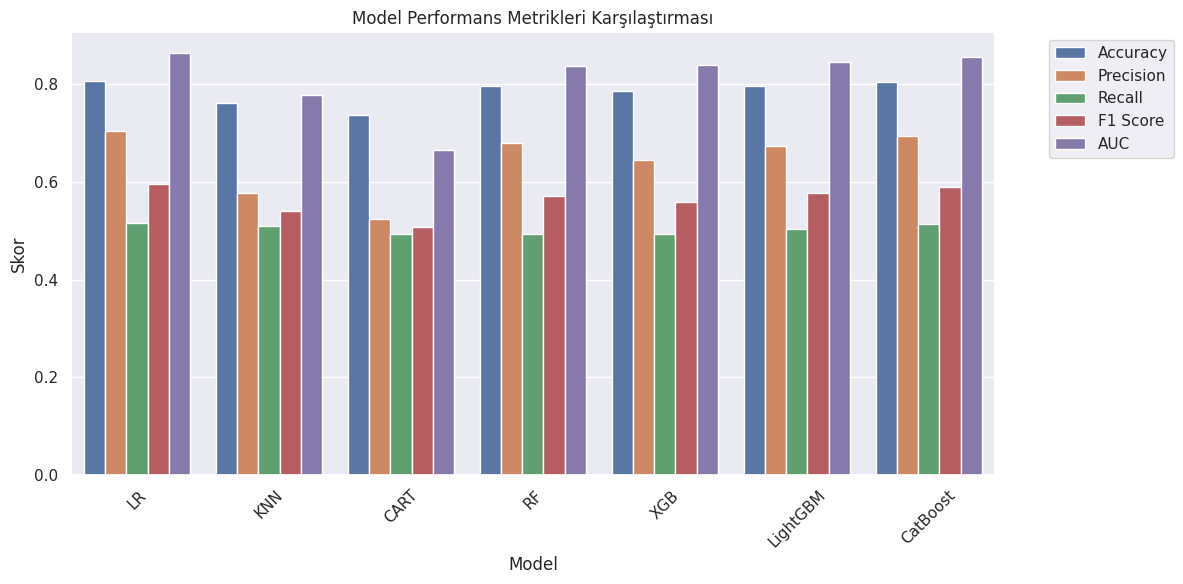

In [72]:
#plotting the comparison graph of the metrics
import matplotlib.pyplot as plt
import seaborn as sns

# transforming result_new_df DataFrame using the "Model" column
result_melt_ = result_new_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

# adjusting the graph
plt.figure(figsize=(12, 6))

# barplot settings
sns.barplot(x="Model", y="Value", hue="Metric", data=result_melt_)

# header and the labels
plt.title("Model Performans Metrikleri Karşılaştırması")
plt.ylabel("Skor")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)  # Legend (açıklama) konumunu ayarlama
plt.tight_layout()

# showing the plot
plt.show()

Feature Importance for LR:
LogisticRegression does not have feature_importances_ attribute
Feature Importance for KNN:
KNeighborsClassifier does not have feature_importances_ attribute
Feature Importance for CART:


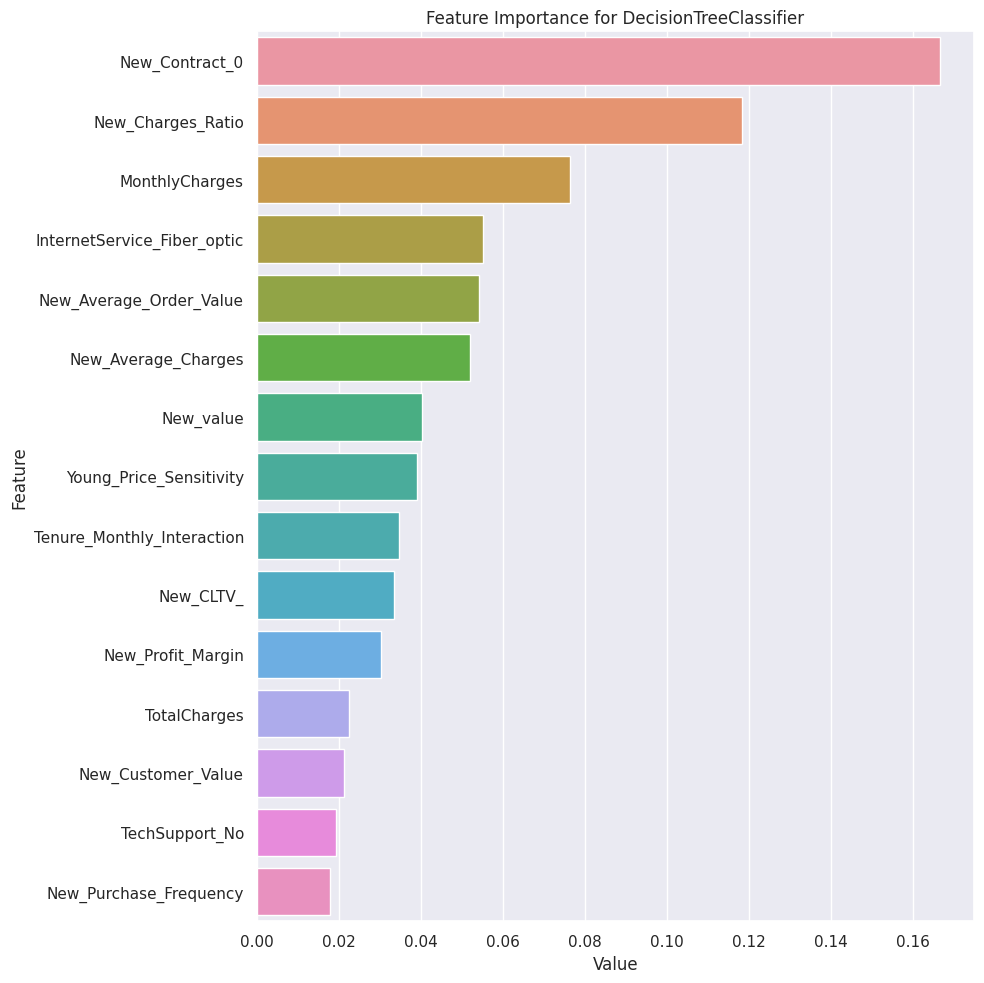

Feature Importance for RF:


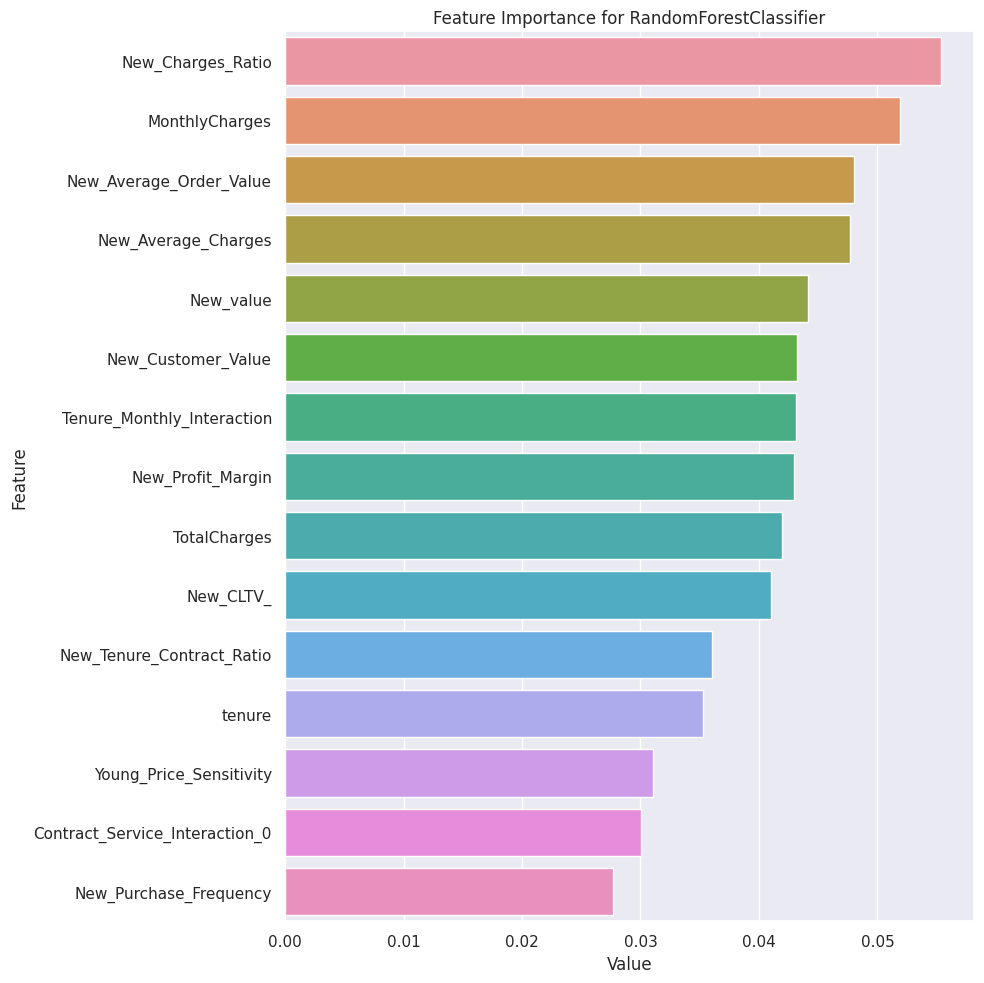

Feature Importance for XGB:


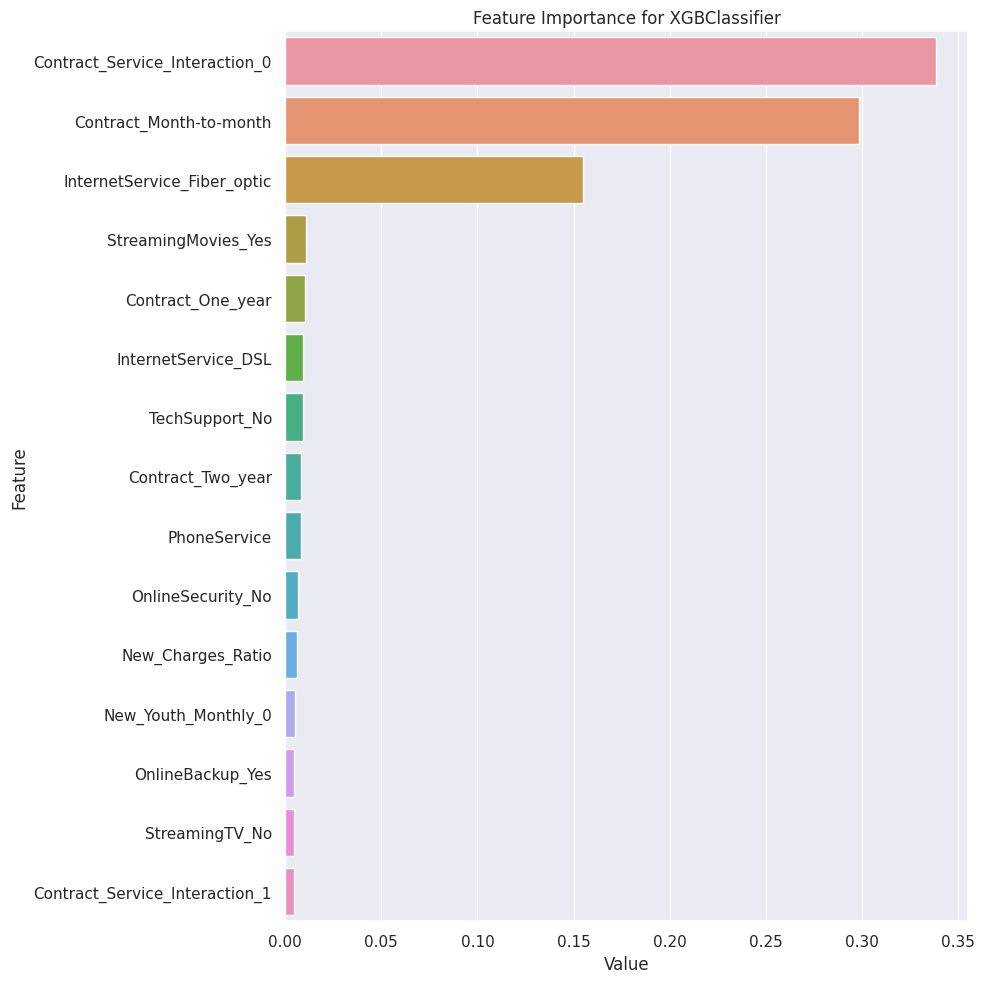

Feature Importance for LightGBM:


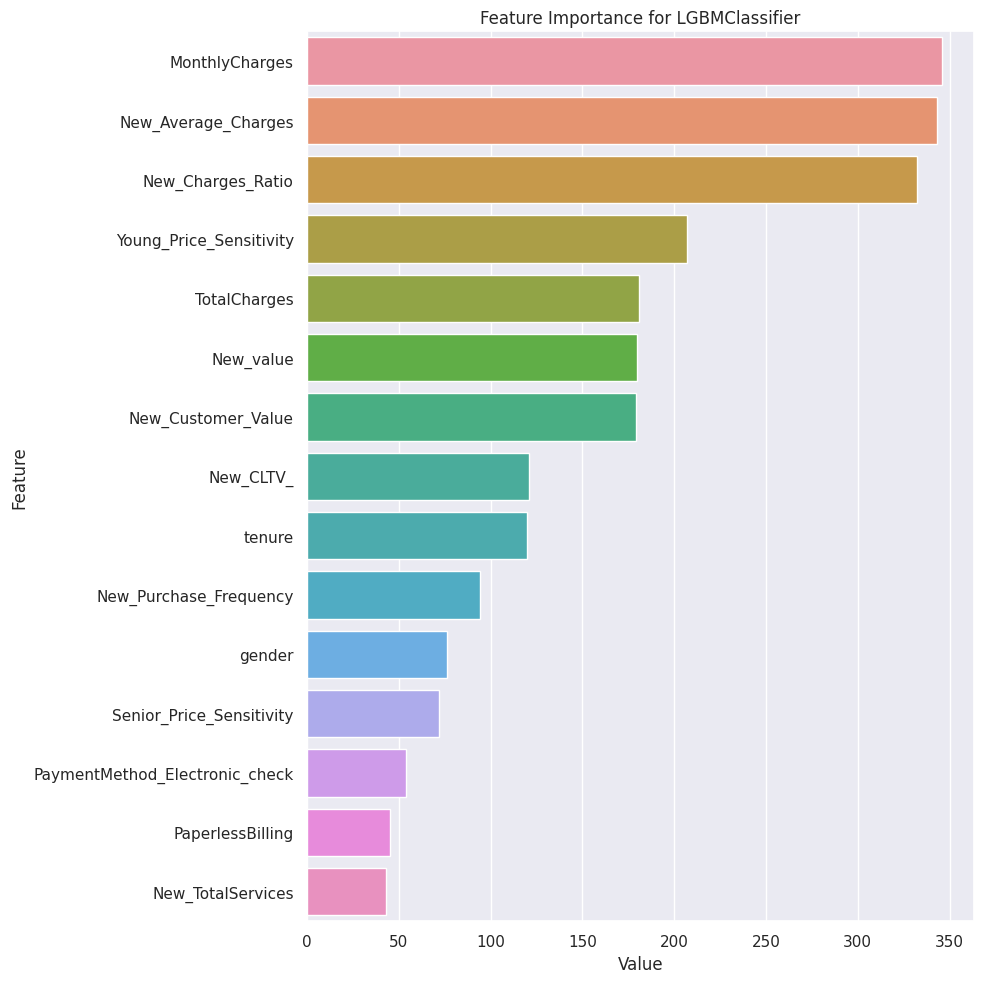

Feature Importance for CatBoost:


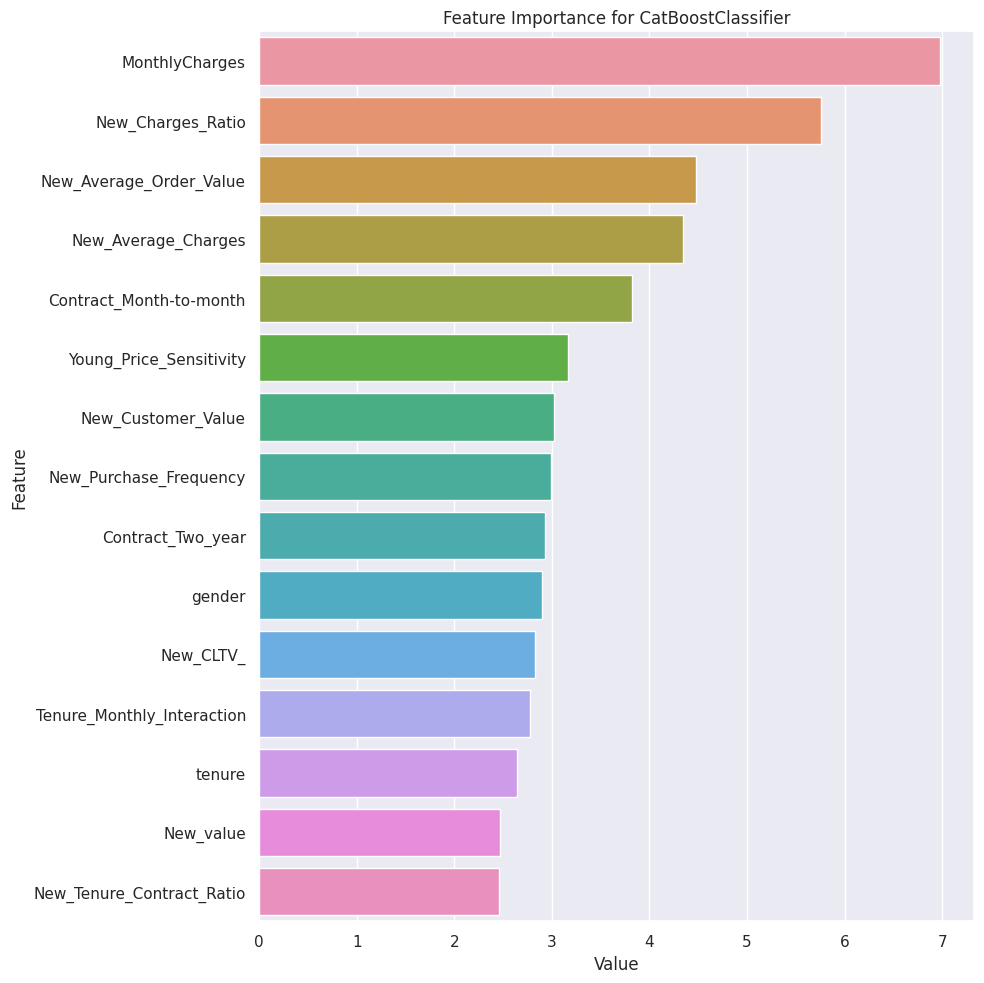

In [73]:
# Function to plot the feature importance
def plot_importance(model, features, num=len(X_train.columns), save=False):
    if hasattr(model, 'feature_importances_'):  # checking to see if the model supports feature importance
        feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
        plt.title(f'Feature Importance for {type(model).__name__}')
        plt.tight_layout()
        plt.show()
        if save:
            plt.savefig(f'{type(model).__name__}_importances.png')
    else:
        print(f"{type(model).__name__} does not have feature_importances_ attribute")

# looping over the models
for model_name, model in models:
    # ploting the grap only for the models that supports feature importance
    print(f"Feature Importance for {model_name}:")
    plot_importance(model, X_train, num=15)


In [74]:
best_models = result_new_df.sort_values(by="F1 Score", ascending=False)
best_models

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,LR,0.808,0.704,0.517,0.596,0.864
6,CatBoost,0.804,0.693,0.514,0.591,0.856
5,LightGBM,0.797,0.675,0.504,0.577,0.847
3,RF,0.797,0.680,0.494,0.572,0.839
4,XGB,0.786,0.645,0.494,0.559,0.839
1,KNN,0.763,0.578,0.509,0.541,0.779
2,CART,0.737,0.523,0.494,0.508,0.665


<div style="text-align: center; font-size: 18px; font-weight: bold; color: purple;">
     Model Optimisation
</div>

In [75]:
results_opt_ = []

# dictinioray for hyperparameters of each model 
param_grids = {
    'LR': {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs'], 'class_weight': ['balanced']},
    'KNN': {'n_neighbors': range(3, 15), 'weights': ['uniform', 'distance']},
    'CART': {'max_depth': [5, 10, 20, 30], 'min_samples_split': [10, 12, 15, 17], 'min_samples_leaf': [5, 10, 15]},
    'RF': {'n_estimators': [50, 100, 200, 300], 'max_depth': [5, 10, 20, 30], 'class_weight': ['balanced']},
    'XGB': {'n_estimators': [100, 200, 300, 500], 'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2]},
    'LightGBM': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'CatBoost': {'iterations': [100, 200], 'learning_rate': [0.001, 0.01, 0.05, 0.1]}
}

# Model names and the objects 
models = [('LR', LogisticRegression(random_state=24689, max_iter=8000)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=24689)),
          ('RF', RandomForestClassifier(random_state=24689)),
          ('XGB', XGBClassifier(random_state=24689)),
          ("LightGBM", LGBMClassifier(random_state=24689, force_row_wise=True)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=24689))]

for model_name, model in models:
    print(f"Model: {model_name}")

    # creating the hyperparameter grid 
    param_grid = param_grids.get(model_name, {}) 

    # identifying the best parameters with GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=10, n_jobs=-1, verbose=0)

    # Training the model on the train set
    grid_search.fit(X_train, y_train)

    # predictions on the Test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # AUC için pozitif sınıfın olasılığı

    # calculating the metrics 
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # getting the best parameters 
    best_params = grid_search.best_params_

    # storing the results 
    results_opt_.append({
        'Model': model_name,
        'Best_Params': best_params,  # En iyi parametreleri ekliyoruz
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'AUC': auc
    })

Model: LR
Model: KNN
Model: CART
Model: RF
Model: XGB
Model: LightGBM
[LightGBM] [Info] Number of positive: 1334, number of negative: 3736
[LightGBM] [Info] Total Bins 3271
[LightGBM] [Info] Number of data points in the train set: 5070, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263116 -> initscore=-1.029834
[LightGBM] [Info] Start training from score -1.029834
[LightGBM] [Info] Number of positive: 1334, number of negative: 3736
[LightGBM] [Info] Total Bins 3271
[LightGBM] [Info] Number of data points in the train set: 5070, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263116 -> initscore=-1.029834
[LightGBM] [Info] Start training from score -1.029834
[LightGBM] [Info] Number of positive: 1333, number of negative: 3737
[LightGBM] [Info] Total Bins 3270
[LightGBM] [Info] Number of data points in the train set: 5070, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262919 -> initscore=-1.0308

In [76]:
#converting the results to a dataframe
import pandas as pd
result_new_df_ = pd.DataFrame(results_opt_)
result_new_df_

,Model,Best_Params,Accuracy,Precision,Recall,F1_Score,AUC
0,LR,"{'C': 0.01, 'class_weight': 'balanced', 'solve...",0.762,0.544,0.822,0.654,0.860
1,KNN,"{'n_neighbors': 9, 'weights': 'uniform'}",0.773,0.600,0.519,0.557,0.809
2,CART,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.793,0.631,0.592,0.611,0.835
3,RF,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.746,0.524,0.809,0.636,0.850
4,XGB,"{'learning_rate': 0.01, 'n_estimators': 500}",0.801,0.684,0.509,0.584,0.854
5,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 100}",0.797,0.675,0.504,0.577,0.847
6,CatBoost,"{'iterations': 200, 'learning_rate': 0.05}",0.804,0.696,0.509,0.588,0.858


In [77]:
#sorting the values by f1_score
best_models_opt = result_new_df_.sort_values(by="F1_Score", ascending=False)
best_models_opt

,Model,Best_Params,Accuracy,Precision,Recall,F1_Score,AUC
0,LR,"{'C': 0.01, 'class_weight': 'balanced', 'solve...",0.762,0.544,0.822,0.654,0.860
3,RF,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.746,0.524,0.809,0.636,0.850
2,CART,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.793,0.631,0.592,0.611,0.835
6,CatBoost,"{'iterations': 200, 'learning_rate': 0.05}",0.804,0.696,0.509,0.588,0.858
4,XGB,"{'learning_rate': 0.01, 'n_estimators': 500}",0.801,0.684,0.509,0.584,0.854
5,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 100}",0.797,0.675,0.504,0.577,0.847
1,KNN,"{'n_neighbors': 9, 'weights': 'uniform'}",0.773,0.600,0.519,0.557,0.809


In [78]:
#comparing the results
comparison_results = best_models.merge(best_models_opt, on='Model', suffixes=('_Before', '_After'))
comparison_results

,Model,Accuracy_Before,Precision_Before,Recall_Before,F1 Score,AUC_Before,Best_Params,Accuracy_After,Precision_After,Recall_After,F1_Score,AUC_After
0,LR,0.808,0.704,0.517,0.596,0.864,"{'C': 0.01, 'class_weight': 'balanced', 'solve...",0.762,0.544,0.822,0.654,0.860
1,CatBoost,0.804,0.693,0.514,0.591,0.856,"{'iterations': 200, 'learning_rate': 0.05}",0.804,0.696,0.509,0.588,0.858
2,LightGBM,0.797,0.675,0.504,0.577,0.847,"{'learning_rate': 0.1, 'n_estimators': 100}",0.797,0.675,0.504,0.577,0.847
3,RF,0.797,0.680,0.494,0.572,0.839,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.746,0.524,0.809,0.636,0.850
4,XGB,0.786,0.645,0.494,0.559,0.839,"{'learning_rate': 0.01, 'n_estimators': 500}",0.801,0.684,0.509,0.584,0.854
5,KNN,0.763,0.578,0.509,0.541,0.779,"{'n_neighbors': 9, 'weights': 'uniform'}",0.773,0.600,0.519,0.557,0.809
6,CART,0.737,0.523,0.494,0.508,0.665,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.793,0.631,0.592,0.611,0.835


**Conslusion;**
Since the target variable 'Churn" has imbalanced distribution, "Accuracy' itself not good indicater of success of the model. We should focus on F1 Score as it is harmonic mean of both Precision and Recall.

The Logisctic Regression model with {'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear'} has the highest F1 score (0.654) and also a strong recall (0.822).

However, its precision (0.544) is slightly lower, indicating that a larger portion of the predicted churners may not actually churn.